# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Predicting Hospital Readmission Rates for Diabetes
## CS109a: Introduction to Data Science



**Harvard University**<br/>
**Fall 2023**<br/>
**Team members**: Karim Gowani, Ryan McGillicuddy, Yaseen Mohmand, Steven Worthington


<hr style="height:2pt">

# Introduction

## i. About This Notebook

This notebook represents a summary of a series of exploratory analysis, wherein we attempt various approaches to classify X-ray images into 14 disease classes and a 'no finding' class. For an overview of the analytical sections of this notebook, please see the [Notebook Contents](#Notebook-Contents) index listed below this Introduction.

### i.i. A note about supporting notebooks

The code and results reported in this notebook are only a summary of the work completed for this project - they represent the final form of our analyses. Supplemental notebooks containing auxillary EDA, data cleaning, and model exploration illustrated in this report can be found in the **`notebooks/`** directory of the **[GitHub project repository](https://github.com/liujinjie111/chestXray)**. The notebooks in this repository are not designed to be run in any particular order to reproduce the results shown in the final report. They just show the extra work and experiments we have tried that are not shown in the final report.

## ii. Research Question

After initial exploration and cleaning of the data, we have focused our efforts on the following research question:

Which model architecture performs best for out-of-sample classification of the X-ray images into the 14 disease classes and 'no finding' class?

## iii. Summary of Findings

We found this project to be both interesting and quite challenging. We created an analysis pipeline using TF datasets that was efficient enough for us to experiment with many different modeling architectures in a short period of time. This encorporated downsampling of the majority image label classes to make modeling more tractable. We incorporated data augmentation steps into the model itself to use GPU, rather than CPU, cycles, thus reducing the computational burden and time cost of preprocessing, allowing us to devote more time to exploring different modelling approaches. 


<a name="Notebook-Contents"></a>
# Notebook Contents

[Introduction](#Introduction)

[Setup](#Setup)

**[1. Data Source and Composition](#1.-Data-Source-and-Composition)**

- [1.1. Data Source and Substantive Context](#1.1.-Data-Source-and-Substantive-Context)

- [1.2. Data Granularity](#1.2.-Data-Granularity)

- [1.3. Class Imbalance](#1.3.-Class-Imbalance)
 
- [1.4. Missing Observations](#1.4.-Missing-Observations)
  
**[2. Exploratory Data Analysis and Preprocessing](#2.-Exploratory-Data-Analysis-and-Preprocessing)**

- [2.1. Exploratory Data Analysis of Raw Data](#2.1.-Exploratory-Data-Analysis-of-Raw-Data)

- [2.2. Data Preprocessing](#2.2.-Data-Preprocessing)

- [2.3. Data Partitioning](#2.3.-Data-Partitioning)
 
- [2.4. Exploratory Data Analysis of Cleaned Data](#2.4.-Exploratory-Data-Analysis-of-Cleaned-Data)

- [2.5. Summary of EDA Key Findings](#2.5.-Summary-of-EDA-Key-Findings)

**[3. Research Questions](#3.-Research-Questions)**

**[4. Modeling Pipeline and Training](#4.-Modeling-Pipeline-and-Training)**

- [4.1. Candidate Models](#4.1.-Candidate-Models)

- [4.2. Model Performance Assessment](#4.2.-Model-Performance-Assessment)

- [4.3. Feature Engineering](#4.3.-Feature-Engineering)

- [4.4. Base Model](#4.4.-Base-Model)

- [4.5. Model Training](#4.5.-Model-Training)

**[5. Model Selection and Evaluation](#5.-Model-Selection-and-Evaluation)**

- [5.1. Model Selection](#5.1.-Model-Selection)

- [5.2. Best Model Performance](#5.2.-Best-Model-Performance)

- [5.3. Variable Importance](#5.3.-Variable-Importance)

**[6. Conclusions](#6.-Conclusions)**

- [6.1. Patient Early Readmittance Rate](#6.1.-Patient-Early-Readmittance-Rate)

- [6.2. Patient Risk Profiles](#6.2.-Patient-Risk-Profiles)

**[7. Future Work](#7.-Future-Work)**

**[8. References](#8.-References)**

# Setup

[Return to top](#Notebook-Contents)

The following sections include general setup code for:
1. Installing the necessary packages needed for data preparation, modeling, and visualization
2. Setting a pseudo-random number seed for reproducibility

### Install Modules

In [1]:
# basic modules
import os
import time
import random as rn
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# plotting style
plt.style.use('seaborn-v0_8-notebook')
# sns.set_style('notebook')
sns.set_style('darkgrid')

# pandas tricks for better display
pd.options.display.max_columns = 50  
pd.options.display.max_rows = 500     
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

# preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

# models
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# metrics & utilities 
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, auc
from sklearn.metrics import average_precision_score, precision_recall_curve, PrecisionRecallDisplay
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.utils import resample

# warnings
import warnings
warnings.filterwarnings("ignore")

# user defined functions
from utility_functions import process_max_glu_serum, process_A1Cresult, process_medical_specialty, process_race
from utility_functions import process_diag_codes, process_age, process_discharge_disposition_id, process_admission_type_id
from utility_functions import process_admission_source_ID, process_readmitted, process_diabetesMed_and_change, preprocess_df
from utility_functions import get_previous_encounters, aggregate_previous_encounters, get_last_encounter, aggregate_encounters
from utility_functions import get_performance_metrics, get_results_df, plot_performance_metrics
from utility_functions import plot_ROC_curves, plot_PR_curves

### Set RNG seed

In [2]:
# ensure replicable results
SEED = 109
np.random.seed(SEED)
rn.seed(SEED)

<a name="1.-Data-Source-and-Composition"></a>
# 1. Data Source and Composition

[Return to top](#Notebook-Contents)

<a name="1.1.-Data-Source-and-Substantive-Context"></a>
## 1.1 Data Source and Substantive Context

[Return to top](#Notebook-Contents)

Our dataset is from the UC Irvine ML Repository and involves patient records of those diagnosed with diabetes from 1999 through 2008 at 130 US hospitals. We have downloaded this dataset and examined it. It has ~102K records, a binary target variable, and 47 features, the majority of which are categorical.

<a name="1.2.-Data-Granularity"></a>
## 1.2 Data Granularity

[Return to top](#Notebook-Contents)

In a clinical setting, doctors and medical staff would like to answer the question, “given information from the current and previous hospitalizations, how likely is it for this patient to be readmitted to hospital early (within 30 days)?”. This question is inherently at the patient-level, but each record in the dataset is at the level of an ‘encounter’, which represents a patient hospitalization event (rather than an outpatient visit). A subset of 16.5% of patients have multiple encounters.

A patient-level perspective is more likely to be of benefit to clinicians, since answering the above question will help medical personnel prioritize follow-ups and interventions through the creation of patient risk profiles, which can identify patients at the highest risk level for early hospital readmittance. This information is actionable and can be used to mitigate negative health outcomes for these patients as well as increased costs for the hospital and insurance carrier. We will therefore aggregate data from the encounter-level to the patient-level.

For those patients with multiple encounters, however, features that vary at the encounter-level contain important information that we do not wish to discard. For example, if a patient was readmitted early relative to the immediately preceding encounter, it is perhaps more likely that the patient will be readmitted to hospital early again after the current encounter. Therefore, our strategy will be to select only the final encounter for these patients and create several new derived features that encapsulate the history of their previous encounters. Such features will include, but are not limited to, the number of previous inpatient encounters, whether the last encounter resulted in early readmission, and whether the patient ever had a high value of A1c.

In following this approach, we will have to make a (reasonable) assumption that encounters for each patient are in temporal order in the dataset because no explicit date information is provided.

<a name="1.3.-Class-Imbalance"></a>
## 1.3 Class Imbalance

[Return to top](#Notebook-Contents)

About 11% of encounters belong to the positive class (readmitted within 30 days), so while there is imbalance, it is not severe. While our performance metric of interest - AUC - is robust to class imbalance, we will still try to address this issue in several ways. We will use stratified sampling in train/test splits, and we will attempt the standard techniques of undersampling and oversampling, as well as use of class weights built into the different ML models of interest, including Logistic Regression, CART, Random Forest, and XG Boost.

<a name="1.4.-Missing-Observations"></a>
## 1.4 Missing Observations

[Return to top](#Notebook-Contents)

There are only 7 (out of 47) relevant columns that contain missing values:
- weight is missing ~97% of its values, so this column can be safely dropped; no other numerical column has missing values.
- medical specialty is missing ~49% of its values, but may be relevant to the classification task, so we keep it and fill the missing values with ‘unknown’..
- payer code (insurance carrier) is missing ~40% of the values, but because it does not seem to be relevant to the target - it is also a candidate for being eliminated altogether.

The remaining columns have less than 3% values missing so they can be managed. They are all categorical, including race and diagnosis codes. As is common for categorical variables, we will fill the missing values with 'unknown'.

<a name="2.-Exploratory-Data-Analysis-and-Preprocessing"></a>
# 2. Exploratory Data Analysis and Preprocessing

[Return to top](#Notebook-Contents)

In this section, we load our raw data, perform some initial exploratory data analysis to assess what pre-processing steps are necessary, perform those preprocessing steps, partition the data into training and testing sets, perform additional exploratory data analysis on the cleaned data, and present a summary of our findings.

<a name="2.1.-Exploratory-Data-Analysis-of-Raw-Data"></a>
## 2.1 Exploratory Data Analysis of Raw Data

[Return to top](#Notebook-Contents)

### Raw Diabetes Data

In [16]:
# load the encounter-level data
df_encounters = pd.read_csv('../data/diabetic_data.csv', 
                            na_values='?',
                            low_memory=False # silence the mixed dtypes warning
                           )
df_encounters.head()

encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)    NaN   
1        149190     55629189        Caucasian  Female  [10-20)    NaN   
2         64410     86047875  AfricanAmerican  Female  [20-30)    NaN   
3        500364     82442376        Caucasian    Male  [30-40)    NaN   
4         16680     42519267        Caucasian    Male  [40-50)    NaN   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1                    7   

   time_in_hospital payer_code         medical_specialty  num_lab_procedures  \
0                 1        NaN  Pediatrics-Endocrinology                  41   
1                 3        NaN                       NaN                  59   
2                 2        NaN                       NaN                  11   
3                 2        NaN                       NaN                  44   
4                 1        NaN                       NaN                  51   

   num_procedures  num_medications  number_outpatient  number_emergency  \
0               0                1                  0                 0   
1               0               18                  0                 0   
2               5               13                  2                 0   
3               1               16                  0                 0   
4               0                8                  0                 0   

   number_inpatient  diag_1  diag_2 diag_3  number_diagnoses max_glu_serum  \
0                 0  250.83     NaN    NaN                 1           NaN   
1                 0     276  250.01    255                 9           NaN   
2                 1     648     250    V27                 6           NaN   
3                 0       8  250.43    403                 7           NaN   
4                 0     197     157    250                 5           NaN   

  A1Cresult metformin repaglinide nateglinide chlorpropamide glimepiride  \
0       NaN        No          No          No             No          No   
1       NaN        No          No          No             No          No   
2       NaN        No          No          No             No          No   
3       NaN        No          No          No             No          No   
4       NaN        No          No          No             No          No   

  acetohexamide glipizide glyburide tolbutamide pioglitazone rosiglitazone  \
0            No        No        No          No           No            No   
1            No        No        No          No           No            No   
2            No    Steady        No          No           No            No   
3            No        No        No          No           No            No   
4            No    Steady        No          No           No            No   

  acarbose miglitol troglitazone tolazamide examide citoglipton insulin  \
0       No       No           No         No      No          No      No   
1       No       No           No         No      No          No      Up   
2       No       No           No         No      No          No      No   
3       No       No           No         No      No          No      Up   
4       No       No           No         No      No          No  Steady   

  glyburide-metformin glipizide-metformin glimepiride-pioglitazone  \
0                  No                  No                       No   
1                  No                  No                       No   
2                  No                  No                       No   
3                  No                  No                       No   
4        

### Data types

In [17]:
# dtypes and columns counts
data_types= df_encounters.dtypes
type_counts = data_types.value_counts()
print(type_counts)

object    37
int64     13
Name: count, dtype: int64


In [18]:
# dtype for each column
data_types

encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                         object
weight                      object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
payer_code                  object
medical_specialty           object
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride         

### Summary Statistics

In [19]:
# summary stats (after removing ID columns)
df_summary = df_encounters[[col for col in df_encounters.columns if not (col.endswith('_id') or col.endswith('_nbr'))]]
df_summary.describe().round(1)

time_in_hospital  num_lab_procedures  num_procedures  num_medications  \
count          101766.0            101766.0        101766.0         101766.0   
mean                4.4                43.1             1.3             16.0   
std                 3.0                19.7             1.7              8.1   
min                 1.0                 1.0             0.0              1.0   
25%                 2.0                31.0             0.0             10.0   
50%                 4.0                44.0             1.0             15.0   
75%                 6.0                57.0             2.0             20.0   
max                14.0               132.0             6.0             81.0   

       number_outpatient  number_emergency  number_inpatient  number_diagnoses  
count           101766.0          101766.0          101766.0          101766.0  
mean                 0.4               0.2               0.6               7.4  
std                  1.3               0.9               1.3               1.9  
min                  0.0               0.0               0.0               1.0  
25%                  0.0               0.0               0.0               6.0  
50%                  0.0               0.0               0.0               8.0  
75%                  0.0               0.0               1.0               9.0  
max                 42.0              76.0              21.0              16.0

### Missing data

We can see that some of the columns have a lot of missing data such as Weight, Max_glu_serum, A1C result. We will be treating these columns in the subsequent cells.

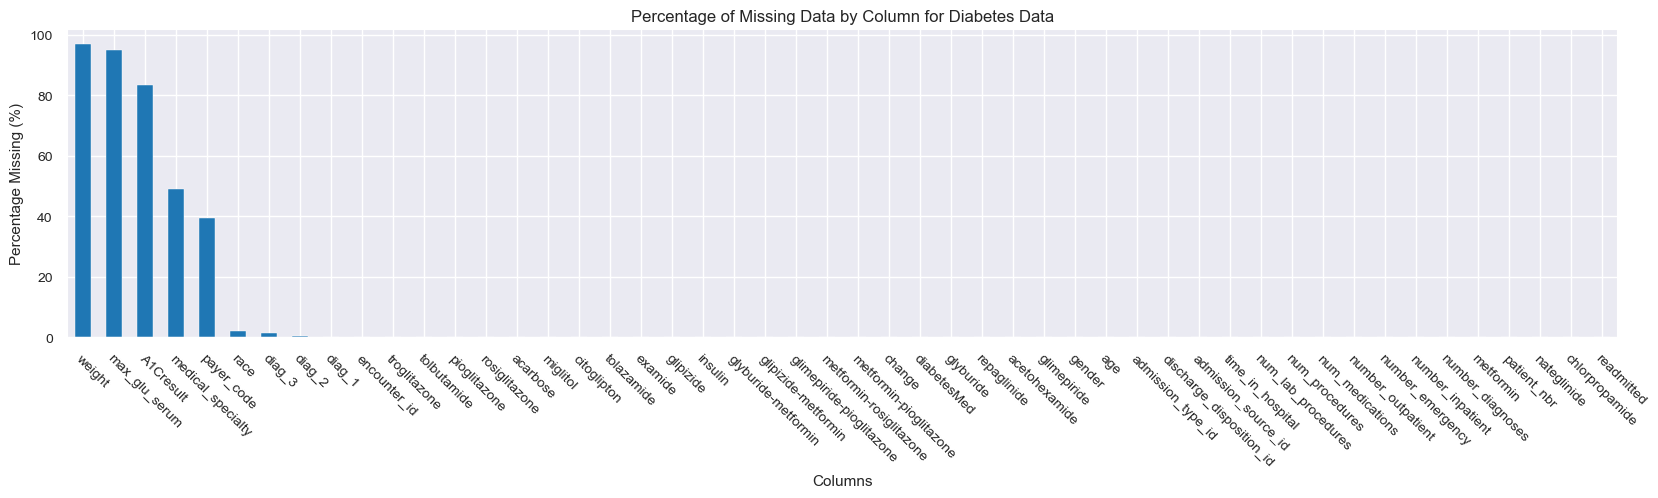

In [24]:
# Calculate missing data percentages
missing_data_percentage = (df_encounters.isnull().sum() / len(df_encounters)) * 100
# Sort the values for better visualization
missing_data_percentage = missing_data_percentage.sort_values(ascending=False)

# Create a figure with specified size
plt.figure(figsize=(20, 4))
# Plot the data as a vertical bar plot
missing_data_percentage.plot(kind='bar')
plt.title('Percentage of Missing Data by Column for Diabetes Data')
plt.xticks(rotation=-45, ha="left", rotation_mode="anchor") 
plt.ylabel('Percentage Missing (%)')
plt.xlabel('Columns');

In [25]:
# missing values table
missing_values = df_encounters.isnull().sum()
missing_percentage = (100 * df_encounters.isnull().sum() / len(df_encounters))
missing_values_table = pd.concat([missing_values, missing_percentage], axis=1)
    
missing_values_table = missing_values_table.rename(
  columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    
missing_values_table = missing_values_table[
    missing_values_table.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    
print(f"The diabetes data have " + str(df_encounters.shape[1]) + " columns.\n"      
    "There are " + str(missing_values_table.shape[0]) +
    " columns that have missing values.\n")

display(missing_values_table)

The diabetes data have 50 columns.
There are 9 columns that have missing values.



Missing Values  % of Total Values
weight                      98569               96.9
max_glu_serum               96420               94.7
A1Cresult                   84748               83.3
medical_specialty           49949               49.1
payer_code                  40256               39.6
race                         2273                2.2
diag_3                       1423                1.4
diag_2                        358                0.4
diag_1                         21                0.0

### Numeric Data

#### Distribution plots

1. Most of our other variable distribution is skewed either to the right or left, which is expected because for example we would not expect a lot of patients to have multiple emergency visits, we would expect the majority to have 0 emergencies and then a long tail.

2. Some of the numeric variables we see more variablility than others. The variables with more variablility might have more predictive power.

3. We can also see that different variables have very different scales, which will make it important for us to scale the normalize/ transform the data if we want to use predictive techniques like k-NN.


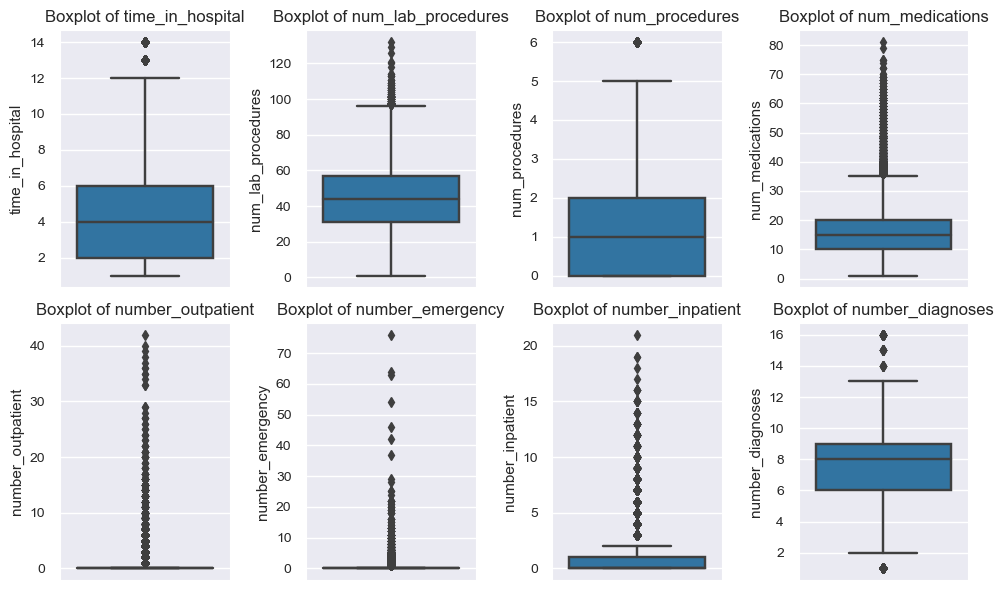

In [29]:
# boxplots for each numeric column
box_vars = ['time_in_hospital', 'num_lab_procedures', 
            'num_procedures', 'num_medications', 'number_outpatient',
            'number_emergency', 'number_inpatient', 'number_diagnoses']

fig, axes = plt.subplots(2, 4, figsize=(10, 6))
for ax, column in zip(axes.flatten(), box_vars):
    sns.boxplot(y=column, data=df_encounters, ax=ax)
    ax.set_title(f'Boxplot of {column}')
plt.tight_layout();

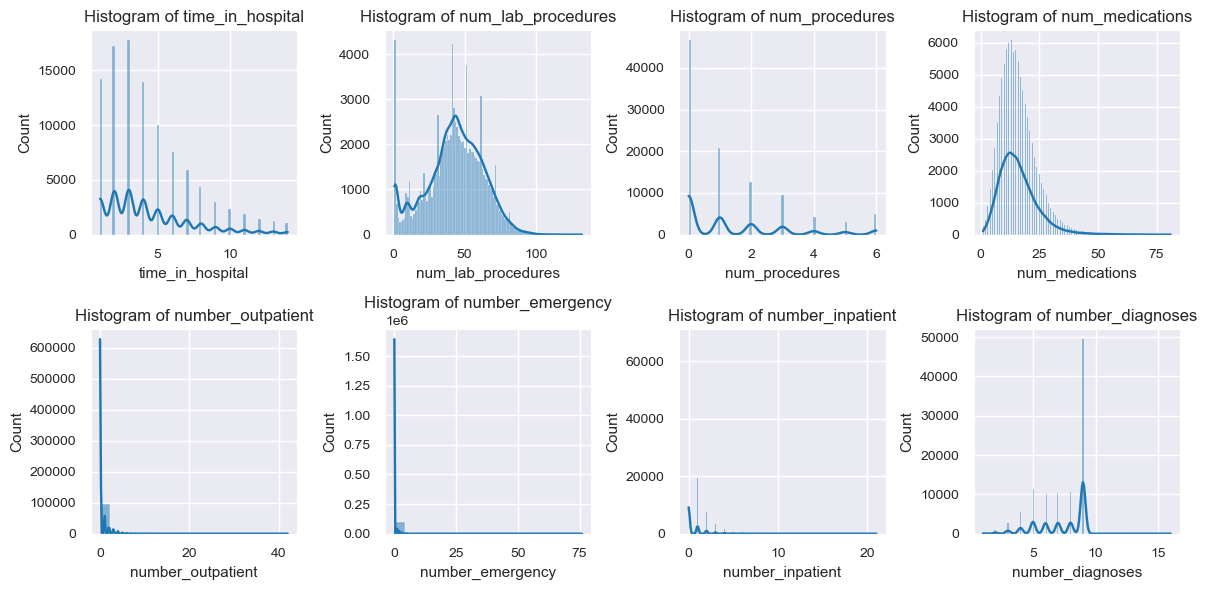

In [31]:
box_vars = ['time_in_hospital', 'num_lab_procedures', 
            'num_procedures', 'num_medications', 'number_outpatient',
            'number_emergency', 'number_inpatient', 'number_diagnoses']

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for ax, column in zip(axes.flatten(), box_vars):
    sns.histplot(df_encounters[column], kde=True, ax=ax)  # using seaborn's histplot
    ax.set_title(f'Histogram of {column}')
plt.tight_layout();

#### Correlation Plots

Our correlation analysis reveals moderate associations among several variables within the dataset. Notably, no pair of variables exhibits an extremely high correlation exceeding the 90% threshold.

Key observations of notable correlations include:

1. A predictable inverse relationship between 'gender_male' and 'gender_female,' as they represent binary and mutually exclusive categories.
2. A discernible correlation between 'race_African American' and 'race_Caucasian,' which likely arises from the demographic representation in the dataset, where Caucasians form the majority and African Americans are the second-largest demographic group.
3. There is an observable correlation between the 'not_readmitted' and 'readmitted_within_30_days' categories. This pattern is attributable to the predominance of the 'not_readmitted' group contrasted with the sizable proportion of cases readmitted within a 30-day period.

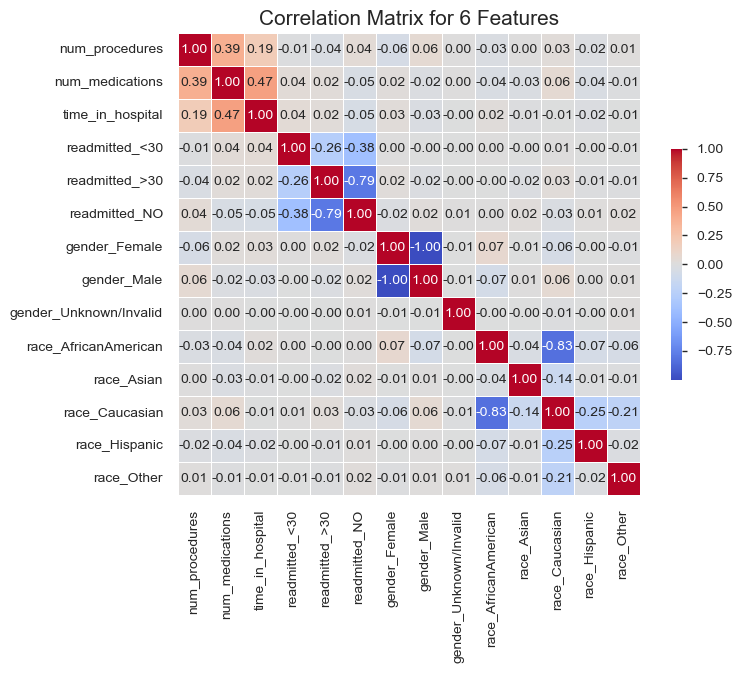

In [33]:
# correlation visualization
cor_vars = ['readmitted', 'gender', 'race', 'num_procedures', 
            'num_medications', 'time_in_hospital']
corr = pd.get_dummies(df_encounters[cor_vars]).corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', 
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation Matrix for 6 Features', fontsize=15);

### Class Imbalance

Our analysis indicates that the target variable, 'readmission within 30 days,' is underrepresented, comprising just 11.15% of the cases, thus confirming a class imbalance in the dataset. This imbalance is a critical factor to consider as it can influence model training and the interpretability of performance metrics.

During the data preparation phase, particularly for train-test splitting, it is essential to maintain a stratified sampling approach. This will ensure that both the training and testing sets reflect the original proportion of the 30-day readmission cases.

In terms of model evaluation, reliance on accuracy as the sole performance metric may be inadequate and potentially misleading due to the skewed class distribution. Alternative metrics such as precision, recall, the F1 score, and the area under the Receiver Operating Characteristic (ROC) curve will be more informative. These metrics can provide a more nuanced view of the model's ability to correctly predict the minority class while distinguishing it from the majority class.

In [34]:
round(df_encounters['readmitted'].value_counts()/(len(df_encounters['readmitted']))*100, 4)

readmitted
NO     53.912
>30    34.928
<30    11.160
Name: count, dtype: float64

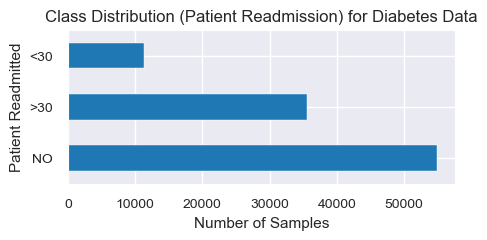

In [35]:
# visualize class imbalance
plt.figure(figsize=(5, 2))
df_encounters['readmitted'].value_counts().plot(kind='barh')
plt.title('Class Distribution (Patient Readmission) for Diabetes Data')
plt.ylabel('Patient Readmitted')
plt.xlabel('Number of Samples');

### Frequency of patient visits

The total number of patients with multiple encounters is 16773. this is 16.48 percent of the data. Majority of the patients only visited the hospital once.

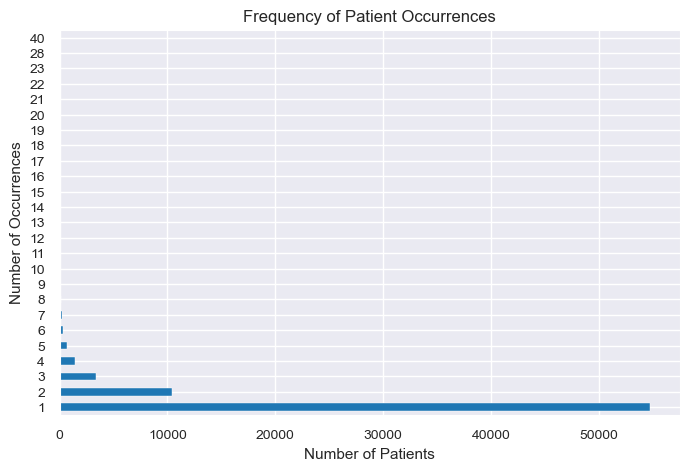

In [36]:
# calculate the frequency of each 'patient_id'
id_counts = df_encounters['patient_nbr'].value_counts()
# count how many 'patient_id's occur for each frequency
frequency_counts = id_counts.value_counts().sort_index()

plt.figure(figsize=(8,5))
frequency_counts.plot(kind='barh')
plt.ylabel('Number of Occurrences')
plt.xlabel('Number of Patients')
plt.title('Frequency of Patient Occurrences');

In [37]:
# group by 'patient_id' and filter out those with only one encounter
multiple_encounters = df_encounters.groupby('patient_nbr').filter(lambda x: len(x) > 1)
print(f"Total number of patients with multple encounters: {multiple_encounters['patient_nbr'].nunique()}")

Total number of patients with multple encounters: 16773


Total number of patients with different outcomes across encounters: 2766



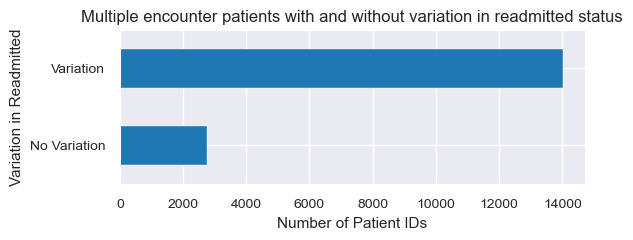

In [38]:
# check if 'readmitted' values vary within each group
def check_variation(df):
    return df['readmitted'].nunique() > 1

variation = multiple_encounters.groupby('patient_nbr').apply(check_variation)

variation_counts = variation.astype(int).value_counts().sort_index()

print(f"Total number of patients with different outcomes across encounters: {variation.value_counts()[1]}\n")

plt.figure(figsize=(6,2))
variation_counts.plot(kind='barh')
plt.xlabel('Number of Patient IDs')
plt.ylabel('Variation in Readmitted')
plt.title('Multiple encounter patients with and without variation in readmitted status')
plt.yticks(ticks=[0, 1], labels=['No Variation', 'Variation']);

In [40]:
variation = multiple_encounters.groupby('patient_nbr')  #.apply(check_variation)
display(variation);

### Categorical Data

#### Age Distribution

The patient age distribution within our dataset skews older, with the majority of patients being over 50 years of age. Age categories under 50 are noticeably less populated, suggesting sparsity in younger demographics.

To streamline our analysis and potentially enhance model performance, we could consider aggregating these sparser younger age groups into a single category during preprocessing. This consolidation could reduce dimensionality and simplify patterns within the data, making it more manageable for subsequent analysis.

In [41]:
# age
df_encounters['age'].value_counts(normalize=True, dropna=False) * 100

age
[70-80)     25.616
[60-70)     22.093
[50-60)     16.957
[80-90)     16.899
[40-50)      9.517
[30-40)      3.709
[90-100)     2.745
[20-30)      1.628
[10-20)      0.679
[0-10)       0.158
Name: proportion, dtype: float64

#### Gender Distribution

Both genders are equally represented in the dataset with slightly more females than males

In [42]:
# gender
df_encounters['gender'].value_counts(normalize=True, dropna=False) * 100

gender
Female             53.759
Male               46.238
Unknown/Invalid     0.003
Name: proportion, dtype: float64

#### Race Distribution

Our dataset's demographic breakdown is predominantly Caucasian, followed by African American as the second-largest racial group. This distribution aligns with the correlations observed earlier, reflecting the demographic representation within the data.

In [43]:
# race
df_encounters['race'].value_counts(normalize=True, dropna=False) * 100

race
Caucasian          74.778
AfricanAmerican    18.877
NaN                 2.234
Hispanic            2.002
Other               1.480
Asian               0.630
Name: proportion, dtype: float64

#### Medical Specialty

Nearly half of the 'medical_specialty' data is missing, yet its relevance for readmission insights means it's worth keeping. Internal Medicine is the predominant specialty, which is typical as it's often a first step before patients move to sub-specialties. Emergency/Trauma and Family/General Practice are also common, reflecting standard hospital intake patterns. Sub-specialties, while less frequent, could be critical in predicting 30-day readmissions and should not be overlooked in predictive modeling.

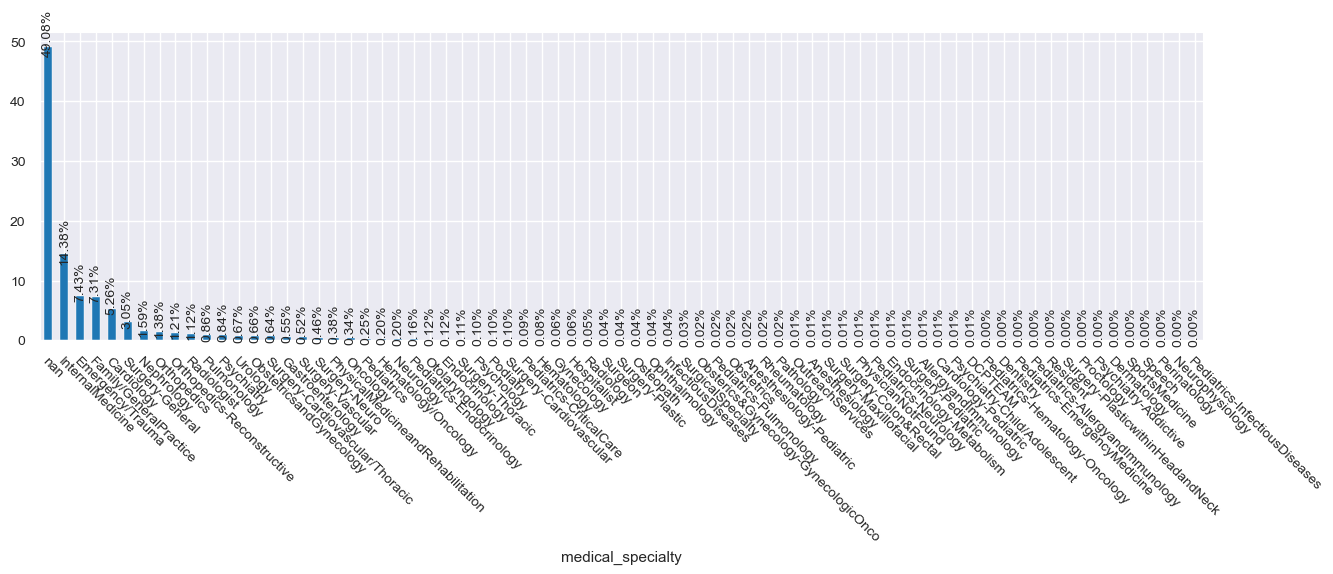

In [49]:
plt.figure(figsize=(15, 4))  # Set the figure size to make sure there's enough room for annotations

medical_speciality = df_encounters['medical_specialty'].value_counts(normalize=True, dropna=False) * 100
ax = medical_speciality.plot(kind='bar')  # Save the Axes object returned by the plot

# Annotate each bar with the percentage
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points', rotation=90)
plt.xticks(rotation=-45, ha="left", rotation_mode="anchor");

<a name="2.2.-Data-Preprocessing"></a>
## 2.2 Data Preprocessing

[Return to top](#Notebook-Contents)

### Overall Strategy

Several of the categorical variables have many categories each that should be easily collapsed to reduce dimensionality:
- At the most extreme, the first diagnosis column has 716 codes, only 23 of which represent more than 1% of the observations; similarly for the second and third diagnosis variables. In fact, these diagnosis codes should be grouped into types such as Circulatory (codes 390-459), respiratory (codes 460-519), digestive (520-579), etc.
- Admission type code has 8 categories, 3 of which make up less than 1% of observations and can be safely collapsed.
- Medical specialty has 72 categories, but only 9 represent more than 1% of the observations.
- Age buckets can be consolidated: Currently, each bucket includes only 10 years. Less than 1% of
the observations fall into age < 20 and age > 90, for instance.

Furthermore, patients who were discharged with codes such as expired, hospice, transferred to another institution as inpatient, etc. should be filtered out as these types of discharge codes are of no practical relevance for predicting the target of early readmission. Trivially, encounter ID and patient ID are mere identifiers and should not be fed into any modeling.

### Columns with Null Values

First, let's examine the number of null values for each feature.

In [3]:
df_encounters.isnull().sum().sort_values(ascending=False).head(10)

weight               98569
max_glu_serum        96420
A1Cresult            84748
medical_specialty    49949
payer_code           40256
race                  2273
diag_3                1423
diag_2                 358
diag_1                  21
encounter_id             0
dtype: int64

#### Weight and Payer Code

Weight jumps out as a feature with a vast majority of null values, so that feature will be dropped from our analysis.

Payer code, a feature related to the indentity of the health insurance provider (Blue Cross Blue Shield, Medicare, etc.) is also a candidate for droppoing both due to high missingness and lower clinical relevance.

#### Max_glu_serum

Let us now examine the rest of features with NaN values, starting with max_glu_serum. Here, none actually signifies that the glucose was not measured, which is clinically relevant, so we keep this feature.

In [4]:
df_encounters['max_glu_serum'].value_counts()

max_glu_serum
Norm    2597
>200    1485
>300    1264
Name: count, dtype: int64

We will replace the NaN values with unknown, to signify that the measurements were not taken. For later processing, we will also create a feature signifying whether the glucose serum test result is high, which we will categorize as a reading > 300.

#### A1C Result

The A1C result is one of the main predictors in the paper describing this dataset. HbA1C is a blood test that measures glycated hemoglobin, with higher values indicating a higher risk for developing diabetes. Chemically, sugar present in the bloodstream reacts with the hemoglobin, forming glycated hemoglobin, and the sugar remains bound for the remainder of the life of the hemoglobin cell, which is several months. Therefore, the A1C level represents a weighted time average of a patient's glucose level over the previous several months.

In [6]:
df_encounters['A1Cresult'].value_counts()

A1Cresult
>8      8216
Norm    4990
>7      3812
Name: count, dtype: int64

As before, none values are clinically relevant (the measurement was not taken) and we will those none values with UNK. For later processing, we again create a feature signifying whether the measurement is high, which we will categorize as a reading > 8.

#### Medical Specialty

The next feature with many missing values is the medical speciality. Examining this feature, we see that there are 72 unique values of medical specialty.

In [8]:
num_spec = len(df_encounters['medical_specialty'].value_counts())
print(f'There are {num_spec} unique specialties')

There are 72 unique specialties


Of the 72 different values of medical specialty, only 9 of them have counts above 1000 in the dataset.

In [9]:
df_encounters['medical_specialty'].value_counts().head(10)

medical_specialty
InternalMedicine              14635
Emergency/Trauma               7565
Family/GeneralPractice         7440
Cardiology                     5352
Surgery-General                3099
Nephrology                     1613
Orthopedics                    1400
Orthopedics-Reconstructive     1233
Radiologist                    1140
Pulmonology                     871
Name: count, dtype: int64

Furthermore, the top 9 specialties acount for 83.90% of the non-NaN encounters.

In [10]:
top9_sum = sum(df_encounters['medical_specialty'].value_counts().head(9))
top9_perc = top9_sum/sum(df_encounters['medical_specialty'].value_counts())

print(f'The top 9 specialties account for {top9_sum} encounters and {top9_perc*100:.2f}% of non-NaN encounters')

The top 9 specialties account for 43477 encounters and 83.90% of non-NaN encounters


Lastly, a distribution of the medical specialty counts shows a long tail, with many medical specialties having low counts in the dataset.

<Axes: xlabel='count', ylabel='medical_specialty'>

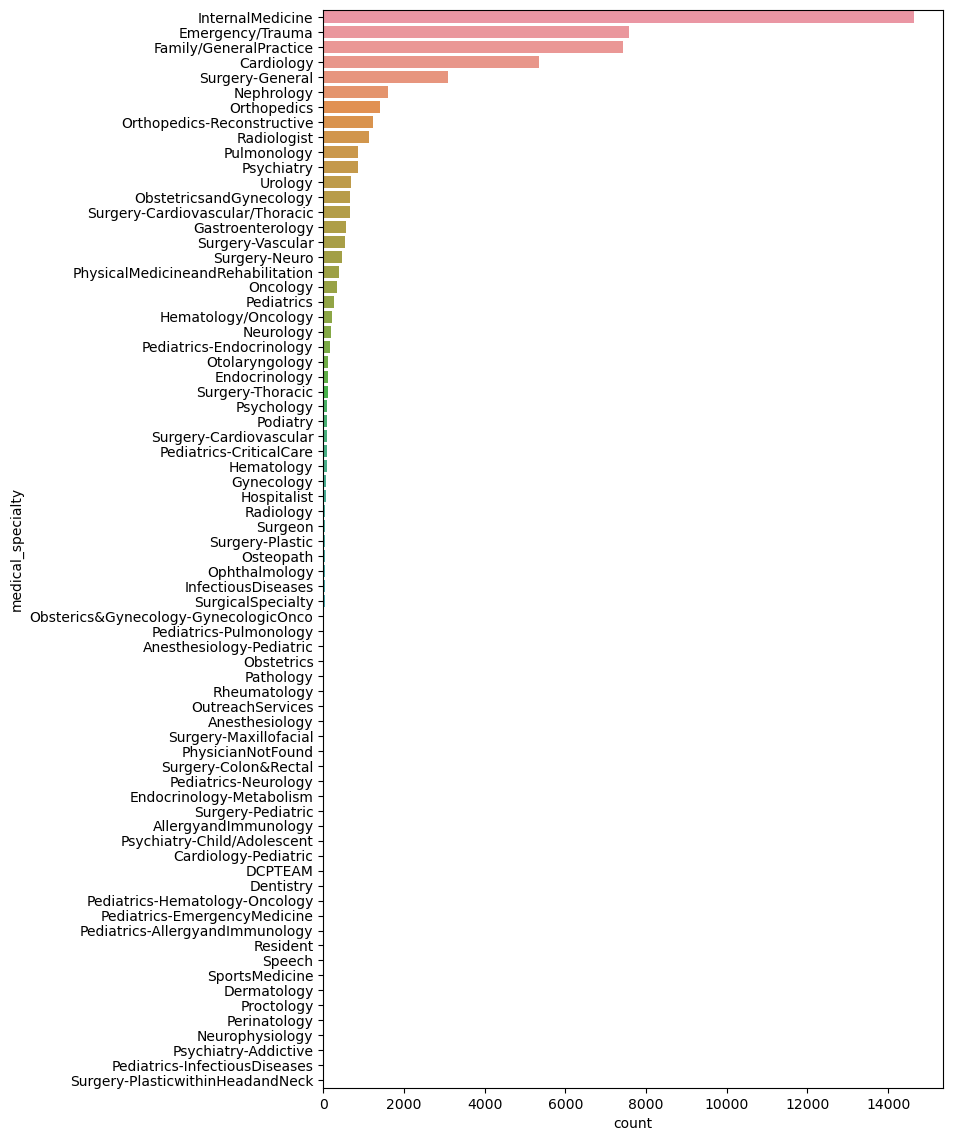

In [11]:
plt.figure(figsize=(8, 14))
sns.barplot(y=df_encounters['medical_specialty'].value_counts().index, x=df_encounters['medical_specialty'].value_counts());

To reduce the potential dimensionality of a one-hot-encoded medical specialty feature and remove medical specialty cateogries that have low counts, we group every medical speciality that has less than 1000 counts, and all NaN values of medical speciality, into a category called other. We maintain all categories of medical specialty that have counts above 1000. We also collapse the two orthopedics categories into one category, as we expect them to be medically similar.

In [12]:
frequent_specialties = df_encounters['medical_specialty'].value_counts().index[:9].values
frequent_specialties

array(['InternalMedicine', 'Emergency/Trauma', 'Family/GeneralPractice',
       'Cardiology', 'Surgery-General', 'Nephrology', 'Orthopedics',
       'Orthopedics-Reconstructive', 'Radiologist'], dtype=object)

#### Race

Only a couple thousand values of race are missing and there are only 5 categories of race.

Text(0.5, 1.0, 'Distributions of Race in Encounter Data')

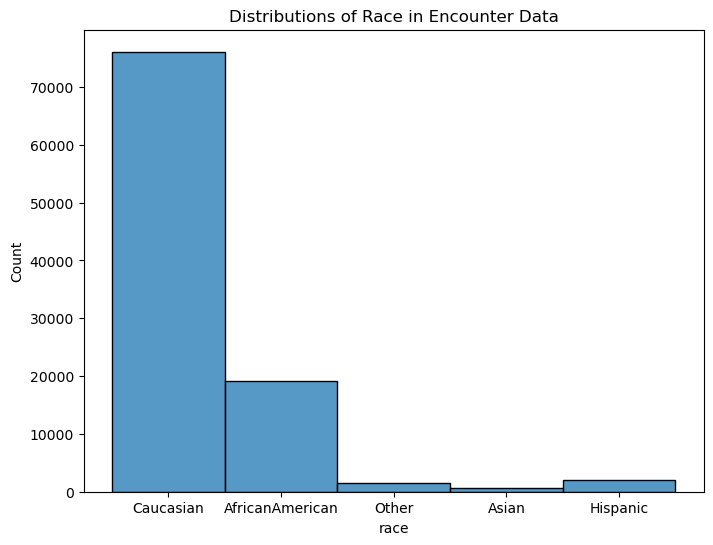

In [14]:
plt.figure(figsize=(8, 6))
sns.histplot(df_encounters['race'], ax=axs)
plt.title('Distributions of Race in Encounter Data');

Given that there are only 5 categories of race, we do not collapse any catgories of race. The NaN values are simply replaced with UNK for unknown.

#### Diagnoses Codes

The 3 diagnoses codes are the last remainining features with NaN values. We will replace these NaN values with unknowns, but the diagnoses features present another challenge. This can be seen by examining the number of unique diagnoses codes used in the dataset.

In [16]:
num_diag1 = df_encounters['diag_1'].value_counts().shape[0]
num_diag2 = df_encounters['diag_2'].value_counts().shape[0]
num_diag3 = df_encounters['diag_2'].value_counts().shape[0]
max_diags = max(num_diag1, num_diag2, num_diag3)

print(f'There are {max_diags} unique diagnoses codes used in the dataset.')

There are 748 unique diagnoses codes used in the dataset.


As described in the paper (https://www.hindawi.com/journals/bmri/2014/781670/), the diagnoses code categories can be collapsed into smaller groups of diagnoses, namely diabetes, circulators, respiratory, digestive, injury, muscoloskeletal, genitournary, neoplasms, and an other category which includes mental disorders, nervous system diseases, pregenancy complication diagnoses, and more. We collapse these categories based on regular expressions to identify the codes belonging to each diagnoses group. The NaN values are replaced with UNK for unknown for the diag_1, diag_2, and diag_3 features.

In [18]:
df_new = process_diag_codes(df_encounters)

In [19]:
df_new['diag_2'].value_counts()

diag_2
other              37860
neoplasms          26931
respiratory        10895
genitournary        8376
diabetes            6723
digestive           4170
injury              3159
musculoskeletal     1764
circulatory         1530
UNK                  358
Name: count, dtype: int64

We have then handled all features that have NaN values. Our next preprocessing steps aim to collapse superfluous categories contained in other features.

### Collapsing Categories in Features with No NaN Values

In order to reduce the dimensionality or cardinality of potentially one-hot-encoded or ordinal categorical variables, we aim to collapse the categories of features when possible. Justifications for collapsing the categories include there being a reason to believe the category will not be predictive for readmission rates, not having enough data in the category, or a strong imbalance in the category relative to other categories in the feature.

#### Age Feature

We find that only ~ 15% of the ages for encounters in this dataset are from ages below 50 years old. We also expect that the response we are trying to predict, readmission within 30 days, is going to be more prevelant in the > 50 years old category. 

In [20]:
def perc_first_n_age_groups(df, n):
    return sum(df_encounters['age'].value_counts(normalize=True).sort_index().values[:n] * 100)

perc = perc_first_n_age_groups(df_encounters, 5)

print(f'The percent of encounters in the dataset below age 50 are {perc:.2f}%')

The percent of encounters in the dataset below age 50 are 15.69%


Additionally, as can be seen from the age distribution plot below, the number of people in the highest age category (90-100 years old) is low, so we collapse that category into the 80-90 years old category.

Text(0.5, 1.0, 'Distribution of Ages')

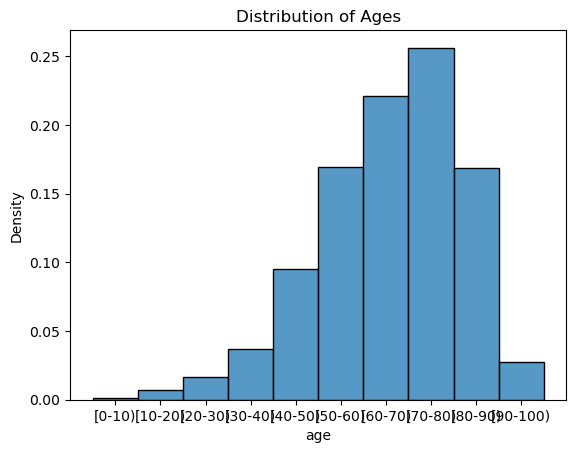

In [21]:
plt.figure(figsize=(10, 5))
sns.histplot(df_encounters['age'], stat='density')
plt.title('Distribution of Ages');

#### Discharge Disposition ID

An examination of the discharge disposition ID values shows a distribution that falls off dramatically after the 1,3 and 6 ID codes, with 85% of discharge disposition IDs belonging to 1, 3, and 6.

In [23]:
def perc_disposition_id_first_n(df, n):
    return sum(df_encounters['discharge_disposition_id'].value_counts()[:3])/sum(df_encounters['discharge_disposition_id'].value_counts())*100

n = 3
perc = perc_disposition_id_first_n(df_encounters, n)
ids = df_encounters['discharge_disposition_id'].value_counts()[:n].index.values
print(f'{perc:.2f}% of the dicharge disposition ids are {ids}.')

85.58% of the dicharge disposition ids are [1 3 6].


In [24]:
df_encounters['discharge_disposition_id'].value_counts().values

array([60234, 13954, 12902,  3691,  2128,  1993,  1642,  1184,   989,
         815,   623,   412,   399,   372,   139,   108,    63,    48,
          21,    14,    11,     8,     6,     5,     3,     2])

Text(0.5, 1.0, 'Frequency of Discharge Disposition IDs in Encounters')

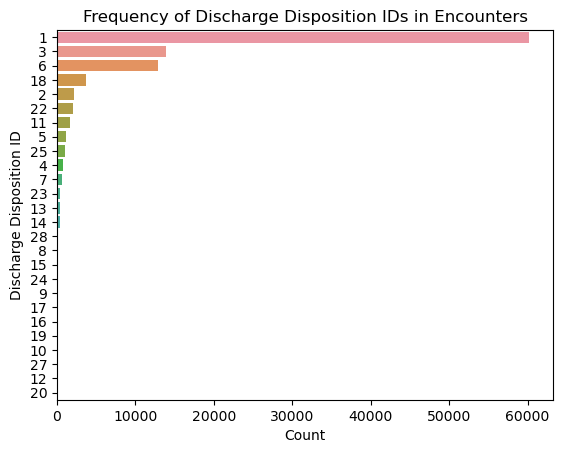

In [25]:
plt.figure(figsize=(10, 5))

ids = [str(id) for id in df_encounters['discharge_disposition_id'].value_counts().index]

sns.barplot(y=ids, x=df_encounters['discharge_disposition_id'].value_counts().values)
plt.xlabel('Count')
plt.ylabel('Discharge Disposition ID')
plt.title('Frequency of Discharge Disposition IDs in Encounters');

Additionally, several ID codes are related to patients that are discharged to hospice or died in the encounter. We do not want to predict on these encounters because the other features will no longer be predictive for a readmission occurance. Therefore, unlike other preprocessing steps discussed so far, for these categories we will drop the encounter (observation).

#### Admission Type ID

Admission type ID ________FILL ME IN, DESCRIBE________. Given the distribution of admission type ids, we keep the top 3 admission type ids and collapse all other admission type ids into an other category. We also add descriptive labels to the ids that are maintained in the dataset.

In [27]:
# maybe generalize this with the above to print out a general % of first n features and their values

def perc_feature_first_n(df, n, feature):
    return sum(df_encounters[feature].value_counts()[:3])/sum(df_encounters[feature].value_counts())*100

n = 3
feature = 'admission_type_id'
perc = perc_feature_first_n(df_encounters, n, feature)
ids = df_encounters[feature].value_counts()[:n].index.values
print(f'{perc:.2f}% of the {feature} ids are {ids}.')

89.75% of the admission_type_id ids are [1 3 2].


Text(0.5, 1.0, 'Frequency of Admission Type IDs in Encounters')

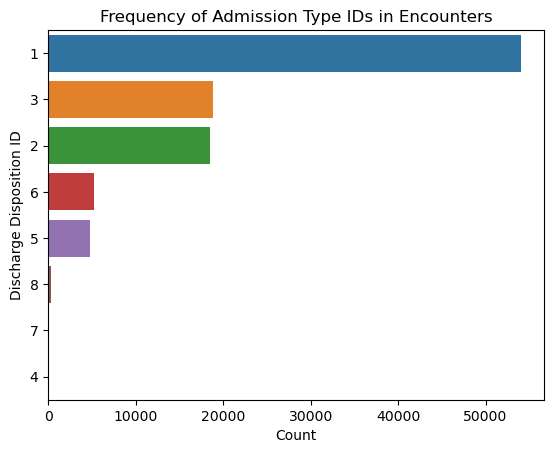

In [28]:
# maybe could also be made into a function
plt.figure(figsize=(7, 5))

ids = [str(id) for id in df_encounters['admission_type_id'].value_counts().index]

sns.barplot(y=ids, x=df_encounters['admission_type_id'].value_counts().values)
plt.xlabel('Count')
plt.ylabel('Discharge Disposition ID')
plt.title('Frequency of Admission Type IDs in Encounters');

#### Admission Source ID

Admission source ID is an integer identifier corresponding different sources of admission into the hospital. Here we finds that the top 2 most frequent admission IDs correspond to greater than 90% of the IDs recorded in the dataset. These IDs, 7 and 1,  correspond to emergency room admission and physician referral, respectively. All other admission IDs are collapsed into an other category.

In [30]:
n = 2
feature = 'admission_source_id'
perc = perc_feature_first_n(df_encounters, n, feature)
ids = df_encounters[feature].value_counts()[:n].index.values
print(f'{perc:.2f}% of the {feature} ids are {ids}.')

92.21% of the admission_source_id ids are [7 1].


Text(0.5, 1.0, 'Frequency of Admission Source IDs in Encounters')

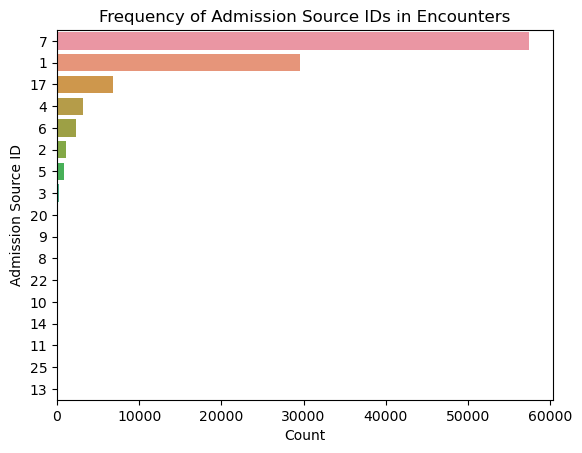

In [31]:
# maybe could also be made into a function
plt.figure(figsize=(7, 5))

ids = [str(id) for id in df_encounters['admission_source_id'].value_counts().index]

sns.barplot(y=ids, x=df_encounters['admission_source_id'].value_counts().values)
plt.xlabel('Count')
plt.ylabel('Admission Source ID')
plt.title('Frequency of Admission Source IDs in Encounters');

#### Readmitted

The readmitted response has 3 values. First, there is NO, which indicates that there was no readmission. Next, there is > 30, which indicates that there was readmission within 30 days. Last, there is < 30, which indicates there was readmission within 30 days. We are interested in predicting readmission within 30 days, so we keep this category and recode it as one. The other two categories are recoded as zero.

In [33]:
df_encounters.readmitted.value_counts()

readmitted
NO     54864
>30    35545
<30    11357
Name: count, dtype: int64

#### Recoding DiabetesMed and Change

Both the diabetesMed and change fetures contain only 2 categories, so we recde these categories into binary categories. In diabetesMed a yes, indicting that a diabetes related medication was prescribed during the encounters, is recoded as a 1. In the change feature a change (ch), indicating a change in the diabetic medications resulting from the visit, is recoded as a 1. No levels are dropped from either of these features.

In [35]:
df_encounters['diabetesMed'].value_counts()

diabetesMed
Yes    78363
No     23403
Name: count, dtype: int64

In [36]:
df_encounters['change'].value_counts()

change
No    54755
Ch    47011
Name: count, dtype: int64

### Combining Preprocessing Functions to Preprocess Data

Here we preprocess the encounter-level data by chaining together functions defined in the `utility_functions.py` file. In addition, we drop the payer code and weight features.

In [38]:
process_list = [process_max_glu_serum, process_A1Cresult, process_medical_specialty, process_race, 
                process_diag_codes, process_age, process_discharge_disposition_id, process_admission_type_id, 
                process_admission_source_ID, process_readmitted, process_diabetesMed_and_change]

In [40]:
df_encounters_processed = preprocess_df(df_encounters, process_list)

In [41]:
df_encounters_processed

encounter_id  patient_nbr             race  gender       age   
0            2278392      8222157        Caucasian  Female    [0-50)  \
1             149190     55629189        Caucasian  Female    [0-50)   
2              64410     86047875  AfricanAmerican  Female    [0-50)   
3             500364     82442376        Caucasian    Male    [0-50)   
4              16680     42519267        Caucasian    Male    [0-50)   
...              ...          ...              ...     ...       ...   
101761     443847548    100162476  AfricanAmerican    Male   [70-80)   
101762     443847782     74694222  AfricanAmerican  Female  [80-100)   
101763     443854148     41088789        Caucasian    Male   [70-80)   
101764     443857166     31693671        Caucasian  Female  [80-100)   
101765     443867222    175429310        Caucasian    Male   [70-80)   

       admission_type_id discharge_disposition_id admission_source_id   
0                  Other                    Other  Physician Referral  \
1              Emergency                     Home      Emergency Room   
2              Emergency                     Home      Emergency Room   
3              Emergency                     Home      Emergency Room   
4              Emergency                     Home      Emergency Room   
...                  ...                      ...                 ...   
101761         Emergency                      SNF      Emergency Room   
101762         Emergency                    Other               Other   
101763         Emergency                     Home      Emergency Room   
101764            Urgent                      SNF      Emergency Room   
101765         Emergency                     Home      Emergency Room   

        time_in_hospital medical_specialty  ...  glyburide-metformin   
0                      1             Other  ...                   No  \
1                      3             Other  ...                   No   
2                      2             Other  ...                   No   
3                      2             Other  ...                   No   
4                      1             Other  ...                   No   
...                  ...               ...  ...                  ...   
101761                 3             Other  ...                   No   
101762                 5             Other  ...                   No   
101763                 1             Other  ...                   No   
101764                10   Surgery-General  ...                   No   
101765                 6             Other  ...                   No   

        glipizide-metformin  glimepiride-pioglitazone   
0                        No                        No  \
1                        No                        No   
2                        No                        No   
3                        No                        No   
4                        No                        No   
...                     ...                       ...   
101761                   No                        No   
101762                   No                        No   
101763                   No                        No   
101764                   No                        No   
101765                   No                        No   

        metformin-rosiglitazone  metformin-pioglitazone  change diabetesMed   
0                            No                      No       0           0  \
1                            No                      No       1           1   
2                            No                      No       0           1   
3                            No                      No       1           1   
4                            No                      No       1           1   
...                         ...                     ...     ...         ...   
101761                       No                      No       1           1   
101762                       No                      No       0           1   
10176

In [42]:
max(df_encounters['patient_nbr'].value_counts())

40

### Data Aggregation

Here we aggregate the encounter-level data to the patient-level, using functions defined in the `utility_functions.py` file.

In [ ]:
df_patient = aggregate_encounters(df_encounters_processed)

In [ ]:
# change binary columns back to categorical to simplify downstream pipeline
for col in df_patient.columns:
    if df_patient[col].nunique()==2 and col != 'readmitted':
        df_patient[col].replace({1:'Yes',0:'No'},inplace=True)

In [48]:
df_patient.shape

(69990, 84)

<a name="2.3.-Data-Partitioning"></a>
## 2.3 Data Partitioning

[Return to top](#Notebook-Contents)

The code snippet provided is designed to divide our dataset into training and testing subsets. Our dataset has an imbalanced 'y' variable. To address this, we employ a stratified splitting approach. This ensures that the proportion of the positive class in both the training and testing sets remains consistent.

### Key Arguments for the Splitting Process:

1. The random state is fixed at 109. This is a deliberate choice to guarantee that our results can be consistently replicated.
2. The sizes of the train/test subsets is established at 80%/20%.

### Post-Split Evaluations:

1. We rigorously confirm that the split is indeed stratified, maintaining the proportional representation of each class.
2. Although not detailed in this notebook, we have conducted additional checks to verify that both the training and testing sets contain comparable representations of patients categorized by the number of visits (specifically, those with a single visit compared to those with multiple visits).

In [62]:
# function to perform data partitioning
def stratified_split(df):
    print('Before splitting the class percentage in our dataset is:',  
          round(df['readmitted'].sum()/len(df['readmitted']), 4))

    y = df['readmitted']
    X = df.drop(columns=['readmitted'])
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        stratify=y, 
        train_size=0.80, 
        random_state=109
    )
    
    print('After splitting the class percentage in train is:', 
          round(y_train.sum()/len(y_train), 4))
    print('After splitting the class percentage in test is:', 
          round(y_test.sum()/len(y_test), 4))

    return X_train, X_test, y_train, y_test

In [55]:
df_patients = pd.read_csv('../data/diabetic_data_processed_2.csv', index_col='patient_nbr')
df_patients.shape

(69990, 84)

In [63]:
# partition the data
X_train, X_test, y_train, y_test = stratified_split(df_patients)

# check the dimensions
X_train.shape, y_train.shape, X_test.shape, y_test.shape

Before splitting the class percentage in our dataset is: 0.0496
After splitting the class percentage in train is: 0.0496
After splitting the class percentage in test is: 0.0496


((55992, 83), (55992,), (13998, 83), (13998,))

<a name="2.4.-Exploratory-Data-Analysis-of-Cleaned-Data"></a>
## 2.4 Exploratory Data Analysis of Cleaned Data

[Return to top](#Notebook-Contents)

### Initial EDA

In [4]:
pd.set_option('display.max_rows', None)
df_patients.dtypes

patient_nbr                            int64
race                                  object
gender                                object
age                                   object
admission_type_id                     object
discharge_disposition_id              object
admission_source_id                   object
time_in_hospital                       int64
medical_specialty                     object
num_lab_procedures                     int64
num_procedures                         int64
num_medications                        int64
number_outpatient                      int64
number_emergency                       int64
number_inpatient                       int64
diag_1                                object
diag_2                                object
diag_3                                object
number_diagnoses                       int64
max_glu_serum                         object
A1Cresult                             object
metformin                             object
repaglinid

In [23]:
# summary stats (after removing ID columns)
df_summary = df_patients[[col for col in df_patients.columns if not (col.endswith('_id') or col.endswith('_nbr'))]]
df_summary.describe().round(1)

time_in_hospital  num_lab_procedures  num_procedures  num_medications  \
count           69990.0             69990.0         69990.0          69990.0   
mean                4.3                43.1             1.4             15.8   
std                 3.0                19.8             1.7              8.2   
min                 1.0                 1.0             0.0              1.0   
25%                 2.0                31.0             0.0             10.0   
50%                 4.0                44.0             1.0             14.0   
75%                 6.0                57.0             2.0             20.0   
max                14.0               129.0             6.0             81.0   

       number_outpatient  number_emergency  number_inpatient  \
count            69990.0           69990.0           69990.0   
mean                 0.3               0.1               0.5   
std                  1.2               0.7               1.0   
min                  0.0               0.0               0.0   
25%                  0.0               0.0               0.0   
50%                  0.0               0.0               0.0   
75%                  0.0               0.0               1.0   
max                 40.0              54.0              19.0   

       number_diagnoses   change  diabetesMed  ...  med_always_changed  \
count           69990.0  69990.0      69990.0  ...             69990.0   
mean                7.3      0.5          0.8  ...                 0.4   
std                 2.0      0.5          0.4  ...                 0.5   
min                 1.0      0.0          0.0  ...                 0.0   
25%                 6.0      0.0          1.0  ...                 0.0   
50%                 8.0      0.0          1.0  ...                 0.0   
75%                 9.0      1.0          1.0  ...                 1.0   
max                16.0      1.0          1.0  ...                 1.0   

       med_ever_changed  avg_times_diabetic_med_prescribed  \
count           69990.0                            69990.0   
mean                0.5                                0.8   
std                 0.5                                0.4   
min                 0.0                                0.0   
25%                 0.0                                0.5   
50%                 0.0                                1.0   
75%                 1.0                                1.0   
max                 1.0                                1.0   

       num_times_diabetic_med_prescribed  diabetic_med_always_prescribed  \
count                            69990.0                         69990.0   
mean                                 1.1                             0.7   
std                                  1.1                             0.4   
min                                  0.0                             0.0   
25%                                  1.0                             0.0   
50%                                  1.0                             1.0   
75%                                  1.0                             1.0   
max                                 39.0                             1.0   

       diabetic_med_ever_prescribed  avg_times_readmitted  \
count                       69990.0               69990.0   
mean                            0.8                   0.1   
std                             0.4                   0.2   
min                             0.0                   0.0   
25%                             1.0                   0.0   
50%                             1.0                   0.0   
75%                             1.0                   0.0   
max                             1.0                   1.0   

       num_times_readmitted  always_readmitted  ever_readmitted  
count               69990.0            69990.0          69990.0  
mean                    0.2                0.0              0.1  
std                     0.5                0.2    

In [5]:
readmittance_rate = df_patients['readmitted'].value_counts(normalize=True)[1]

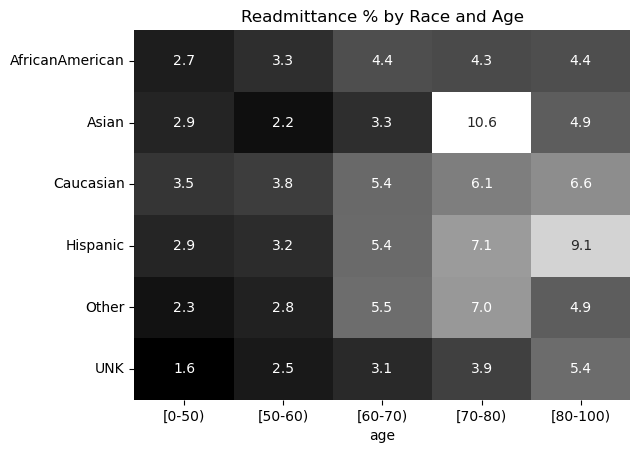

In [47]:
table = df_patients.pivot_table(index="race", columns="age", values="readmitted", aggfunc="mean").apply(lambda x:x*100)
ax = sns.heatmap(table,cmap='gray',annot=True,fmt='.1f',cbar=None)
ax.set_ylabel('');
ax.set_title('Readmittance % by Race and Age');

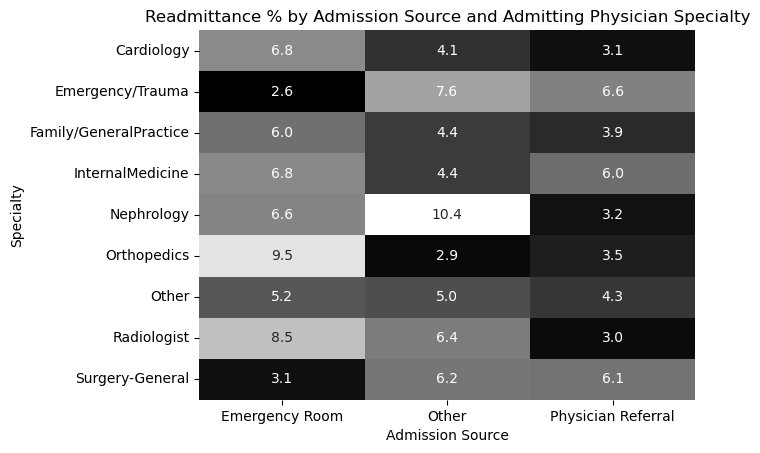

In [56]:
table = df_patients.pivot_table(index="medical_specialty", columns="admission_source_id", values="readmitted", aggfunc="mean").apply(lambda x:x*100)
ax = sns.heatmap(table,cmap='gray',annot=True,fmt='.1f',cbar=None)
ax.set_ylabel('');
ax.set_title('Readmittance % by Admission Source and Admitting Physician Specialty')
ax.set_ylabel('Specialty')
ax.set_xlabel('Admission Source');

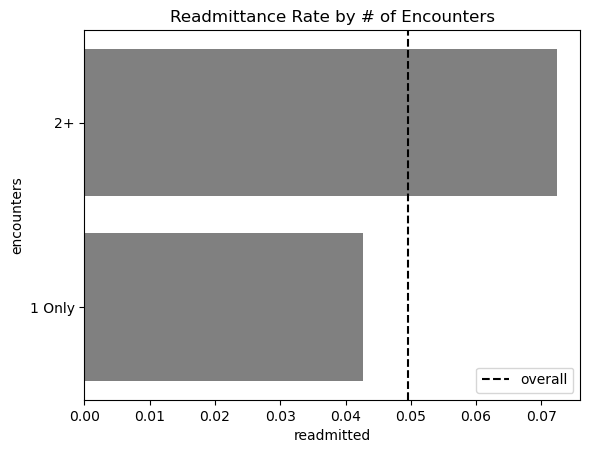

In [6]:
df_patients['encounters']=df_patients.num_encounters.apply(lambda v: '2+' if v>1 else '1 Only')
ax = sns.barplot(data=df_patients,y='encounters',x='readmitted',color='gray', errorbar=None)
ax.axvline(x=readmittance_rate,color='black',linestyle='--',label='overall')
ax.set_title('Readmittance Rate by # of Encounters')
ax.legend();

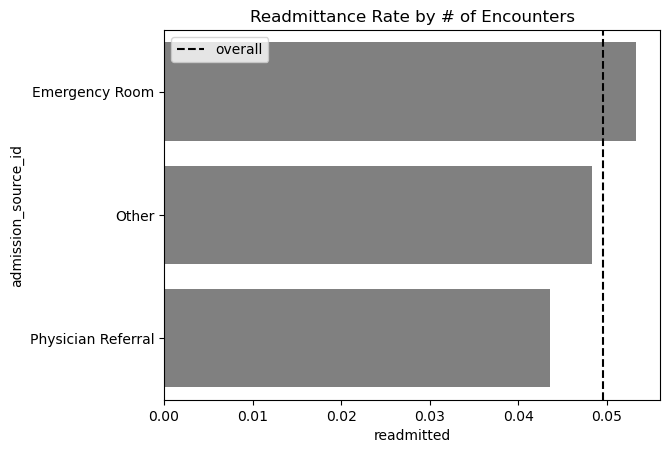

In [65]:
ax = sns.barplot(data=df_patients,y='admission_source_id',x='readmitted',color='gray', errorbar=None,
                order=['Emergency Room', 'Other','Physician Referral'])
ax.axvline(x=readmittance_rate,color='black',linestyle='--',label='overall')
ax.set_title('Readmittance Rate by # of Encounters')
ax.legend();

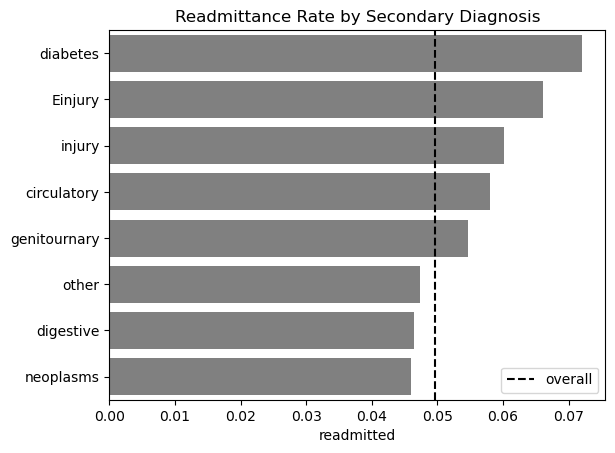

In [52]:
ax = sns.barplot(data=df_patients,y='diag_3',x='readmitted',color='gray', errorbar=None,
                 order=['diabetes','Einjury','injury','circulatory','genitournary','other',
                        'digestive','neoplasms'])
ax.axvline(x=readmittance_rate,color='black',linestyle='--',label='overall')
ax.set_title('Readmittance Rate by Secondary Diagnosis')
ax.set_ylabel('')
ax.legend();

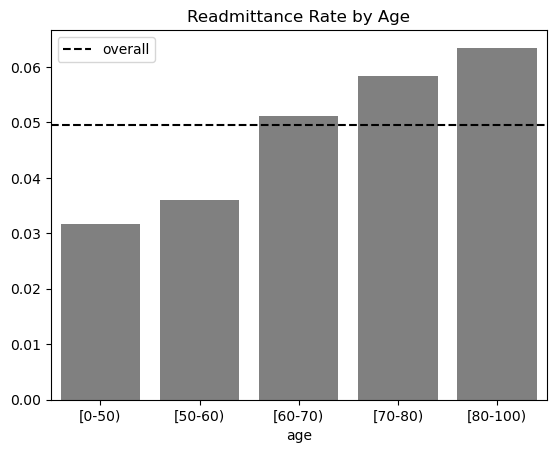

In [70]:
ax = sns.barplot(data=df_patients,x='age',y='readmitted',color='gray', errorbar=None,
                order=['[0-50)','[50-60)','[60-70)','[70-80)','[80-100)'])
ax.axhline(y=readmittance_rate,color='black',linestyle='--',label='overall')
ax.set_title('Readmittance Rate by Age')
ax.set_ylabel('')
ax.legend();

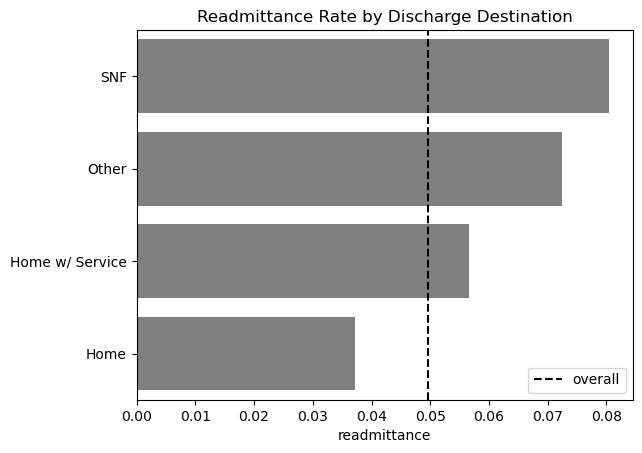

In [12]:

ax = sns.barplot(data=df_patients,y='discharge_disposition_id',x='readmitted',color='gray', errorbar=None,
                order=['SNF','Other','Home w/ Service','Home'])
ax.axvline(x=readmittance_rate,color='black',linestyle='--',label='overall')
ax.set_title('Readmittance Rate by Discharge Destination')
ax.set_xlabel('readmittance')
ax.set_ylabel('')
ax.legend();

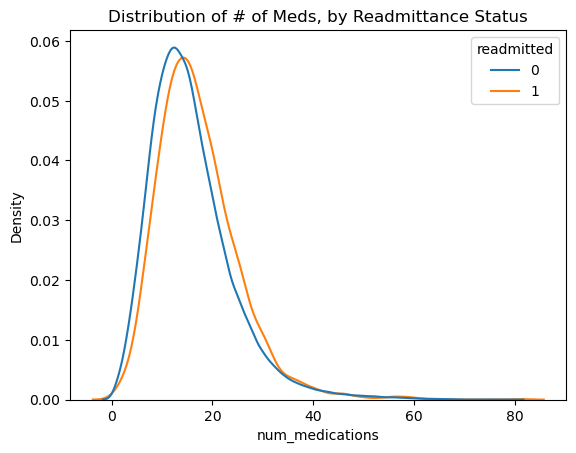

In [71]:
sns.kdeplot(data=df_patients,x='num_medications',hue='readmitted',common_norm=False).set_title('Distribution of # of Meds, by Readmittance Status');

<Axes: xlabel='num_lab_procedures', ylabel='Density'>

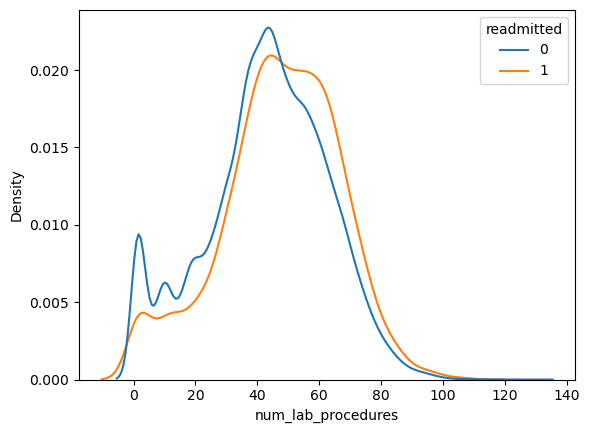

In [25]:
sns.kdeplot(data=df_patients,x='num_lab_procedures',hue='readmitted',common_norm=False);

<Axes: xlabel='num_medications', ylabel='Density'>

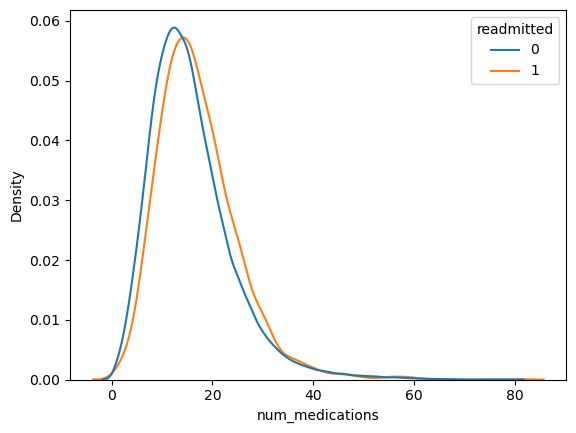

In [26]:
sns.kdeplot(data=df_patients,x='num_medications',hue='readmitted',common_norm=False);

<Axes: xlabel='avg_time_in_hospital', ylabel='Density'>

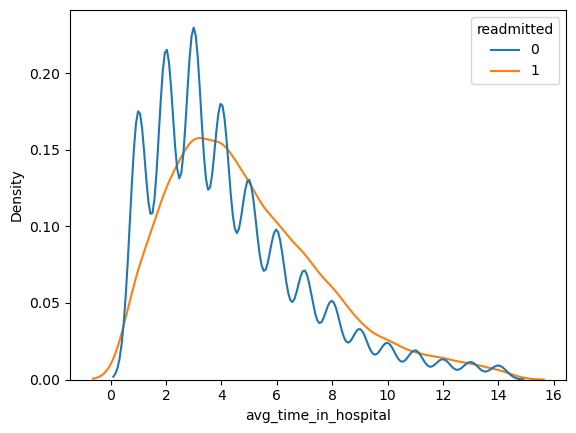

In [32]:
sns.kdeplot(data=df_patients,x='avg_time_in_hospital',hue='readmitted',common_norm=False);

<Axes: xlabel='max_time_in_hospital', ylabel='Density'>

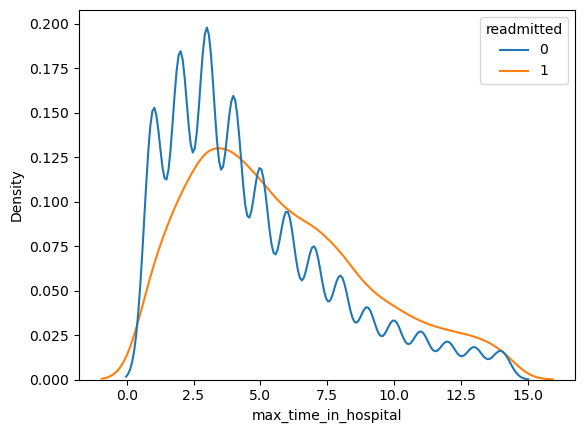

In [34]:
sns.kdeplot(data=df_patients,x='max_time_in_hospital',hue='readmitted',common_norm=False);

In [3]:
df_patients.readmitted.value_counts(normalize=True)*100

readmitted
0    95.043578
1     4.956422
Name: proportion, dtype: float64

### Correlations

In [5]:
# Checking correlation between the float columns and readmission

int_columns=df.select_dtypes(['int']).drop('patient_nbr', axis=1).columns

# Initialize lists to store the results
cor_list = []
col_list = []

# Loop through each column in the integer columns list
for col in int_columns:
    col_list.append(col)
    # Compute correlation between the column and 'readmitted'
    cor_value = np.corrcoef(df[col], df['readmitted'])[0, 1]
    cor_list.append(cor_value)

# Create a DataFrame with the results
correlation_df = pd.DataFrame({
    'Column': col_list,
    'CorrelationWithReadmitted': cor_list
})

# Now you can print or display the DataFrame
correlation_df.sort_values('CorrelationWithReadmitted', ascending=False)

Column  CorrelationWithReadmitted
10                         readmitted                  1.000e+00
37                  always_readmitted                  8.430e-01
38                    ever_readmitted                  6.020e-01
36               num_times_readmitted                  4.610e-01
6                    number_inpatient                  1.386e-01
11                     num_encounters                  6.806e-02
13               max_time_in_hospital                  6.643e-02
33  num_times_diabetic_med_prescribed                  6.481e-02
15             max_num_lab_procedures                  6.457e-02
21                      max_diagnoses                  5.977e-02
7                    number_diagnoses                  5.516e-02
0                    time_in_hospital                  4.943e-02
1                  num_lab_procedures                  4.940e-02
30              num_times_med_changed                  4.818e-02
19                max_num_medications                  4.766e-02
20                      min_diagnoses                  4.009e-02
3                     num_medications                  3.761e-02
5                    number_emergency                  3.529e-02
12               min_time_in_hospital                  3.116e-02
35       diabetic_med_ever_prescribed                  2.752e-02
14             min_num_lab_procedures                  2.588e-02
26                 unique_a1c_results                  2.559e-02
4                   number_outpatient                  2.159e-02
9                         diabetesMed                  2.060e-02
18                min_num_medications                  2.014e-02
32                   med_ever_changed                  1.992e-02
23                 num_times_glu_high                  1.576e-02
34     diabetic_med_always_prescribed                  1.387e-02
22            unique_glu_measurements                  1.114e-02
8                              change                  1.063e-02
25                      glu_ever_high                  1.029e-02
17                 max_num_procedures                  6.611e-03
24                    glu_always_high                  2.165e-05
31                 med_always_changed                 -1.712e-03
27                 num_times_a1c_high                 -3.101e-03
29                      a1c_ever_high                 -3.939e-03
2                      num_procedures                 -7.932e-03
28                    a1c_always_high                 -1.566e-02
16                 min_num_procedures                 -2.009e-02

In [6]:
# Checking corelation between the X variables

# Set your threshold
upper_threshold = 0.99
lower_threshold=0.5

# Calculate the correlation matrix
int_df = df.select_dtypes(include=['int', 'int64'])
corr_matrix = int_df.corr()

# Apply the threshold to the correlation matrix and find pairs with high correlation
high_corr_pairs = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
                   .stack()
                   .reset_index())
high_corr_pairs.columns = ['col1', 'col2', 'corr_value']

# Filter out the pairs with correlation above the threshold
high_corr_pairs = high_corr_pairs[(high_corr_pairs['corr_value'] > lower_threshold )& (high_corr_pairs['corr_value'] < upper_threshold ) ]
high_corr_pairs.sort_values('corr_value',ascending=False)

col1                               col2  \
297                   number_diagnoses                      max_diagnoses   
370                        diabetesMed       diabetic_med_ever_prescribed   
715                 num_times_a1c_high                      a1c_ever_high   
127                     num_procedures                 min_num_procedures   
369                        diabetesMed     diabetic_med_always_prescribed   
338                             change                   med_ever_changed   
165                    num_medications                max_num_medications   
337                             change                 med_always_changed   
296                   number_diagnoses                      min_diagnoses   
90                  num_lab_procedures             max_num_lab_procedures   
164                    num_medications                min_num_medications   
89                  num_lab_procedures             min_num_lab_procedures   
128                     num_procedures                 max_num_procedures   
51                    time_in_hospital               max_time_in_hospital   
50                    time_in_hospital               min_time_in_hospital   
609                      min_diagnoses                      max_diagnoses   
770     diabetic_med_always_prescribed       diabetic_med_ever_prescribed   
400                         readmitted                  always_readmitted   
752                 med_always_changed                   med_ever_changed   
423                     num_encounters  num_times_diabetic_med_prescribed   
570                min_num_medications                max_num_medications   
725                    a1c_always_high                      a1c_ever_high   
661                 num_times_glu_high                      glu_ever_high   
527                 min_num_procedures                 max_num_procedures   
778               num_times_readmitted                    ever_readmitted   
480             min_num_lab_procedures             max_num_lab_procedures   
746              num_times_med_changed  num_times_diabetic_med_prescribed   
429               min_time_in_hospital               max_time_in_hospital   
675                    glu_always_high                      glu_ever_high   
714                 num_times_a1c_high                    a1c_always_high   
745              num_times_med_changed                   med_ever_changed   
426                     num_encounters               num_times_readmitted   
256                   number_inpatient                     num_encounters   
336                             change              num_times_med_changed   
420                     num_encounters              num_times_med_changed   
401                         readmitted                    ever_readmitted   
767  num_times_diabetic_med_prescribed               num_times_readmitted   
281                   number_inpatient               num_times_readmitted   
660                 num_times_glu_high                    glu_always_high   
278                   number_inpatient  num_times_diabetic_med_prescribed   
766  num_times_diabetic_med_prescribed       diabetic_med_ever_prescribed   
744              num_times_med_changed                 med_always_changed   
761                   med_ever_changed       diabetic_med_ever_prescribed   
315                             change                        diabetesMed   
779                  always_readmitted                    ever_readmitted   
754                 med_always_changed     diabetic_med_always_prescribed   

     corr_value  
297       0.952  
370       0.927  
715       0.924  
127       0.921  
369       0.920  
338       0.915  
165       0.913  
337       0.910  
296       0.908  
90        0.907  
164       0.904  
89        0.890  
128       0.888  
51        0.884  
50        0.877  
609       0.859  
770       0.854  
400       0.843  
752       0.832  
423       0.826  
570       0.814  
725       0.813  


### Class Imbalance

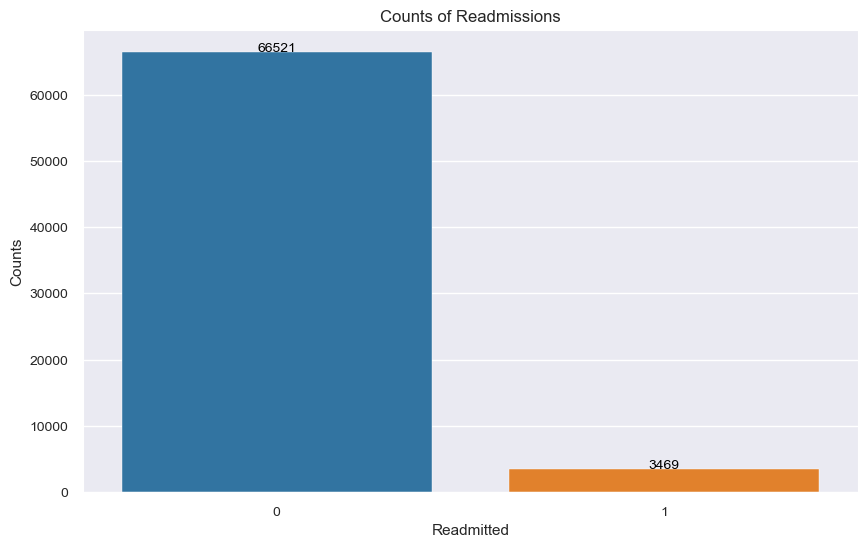

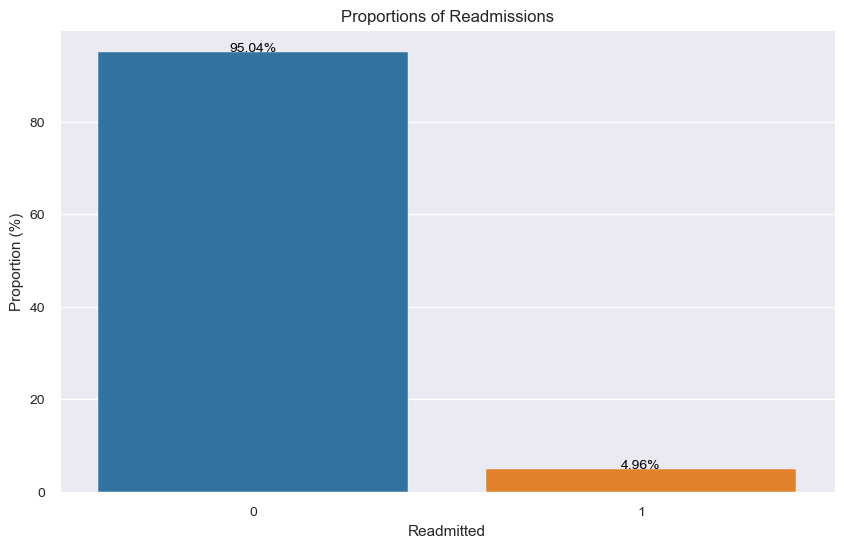

In [7]:
# Calculate counts
value_counts = df['readmitted'].value_counts()

# Calculate proportions
proportions = df['readmitted'].value_counts(normalize=True) * 100

# Create a DataFrame from the counts and proportions
data_to_plot = pd.DataFrame({'Counts': value_counts, 'Proportions': proportions})

# Plot a bar graph using the counts
plt.figure(figsize=(6, 3))

# Create a bar plot for the counts
count_plot = sns.barplot(x=data_to_plot.index, y=data_to_plot['Counts'])

# Annotate each bar with the count value
for index, value in enumerate(data_to_plot['Counts']):
    count_plot.text(index, value, f'{value}', color='black', ha="center")

plt.title('Counts of Readmissions')
plt.xlabel('Readmitted')
plt.ylabel('Counts');

# Plot a bar graph using the proportions
plt.figure(figsize=(6, 3))

# Create a bar plot for the proportions
prop_plot = sns.barplot(x=data_to_plot.index, y=data_to_plot['Proportions'])

# Annotate each bar with the proportion value
for index, value in enumerate(data_to_plot['Proportions']):
    prop_plot.text(index, value, f'{value:.2f}%', color='black', ha="center")

plt.title('Proportions of Readmissions')
plt.xlabel('Readmitted')
plt.ylabel('Proportion (%)');

### Distributions of All Features

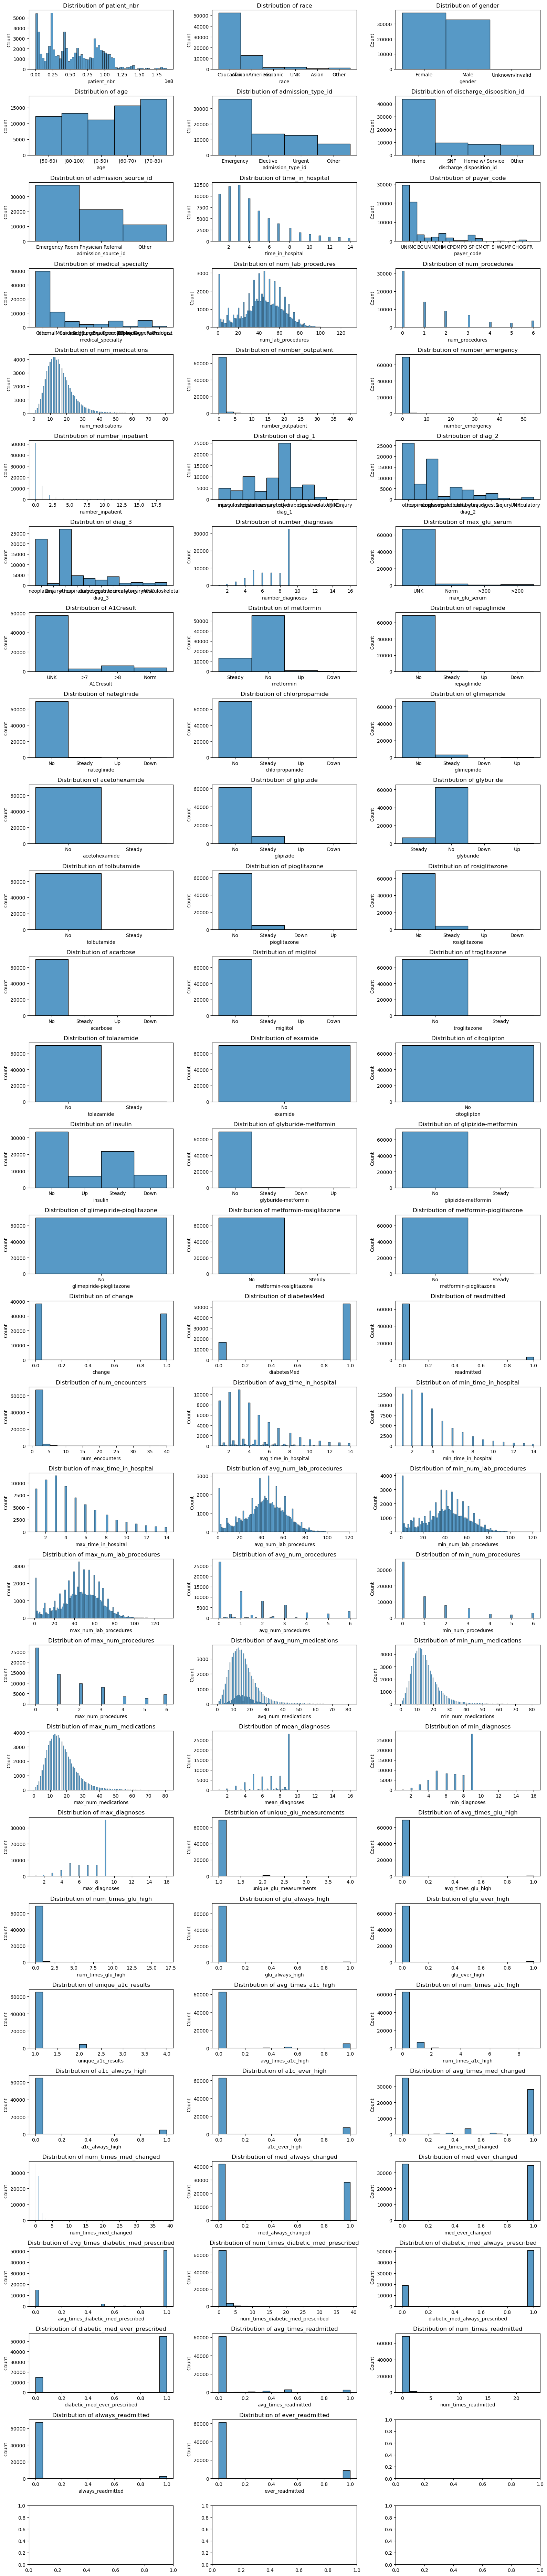

In [15]:
fig, axs = plt.subplots(30,3, figsize=(16, 75))
axs = axs.ravel()
omit = ['patient_nbr']

for i,col in enumerate(df_patients.columns):
    sns.histplot(df_patients[col], ax=axs[i], alpha=0.75)
    axs[i].set_title(f'Distribution of {col}')
plt.tight_layout()

### Density Histogram Plots, Linear Scale

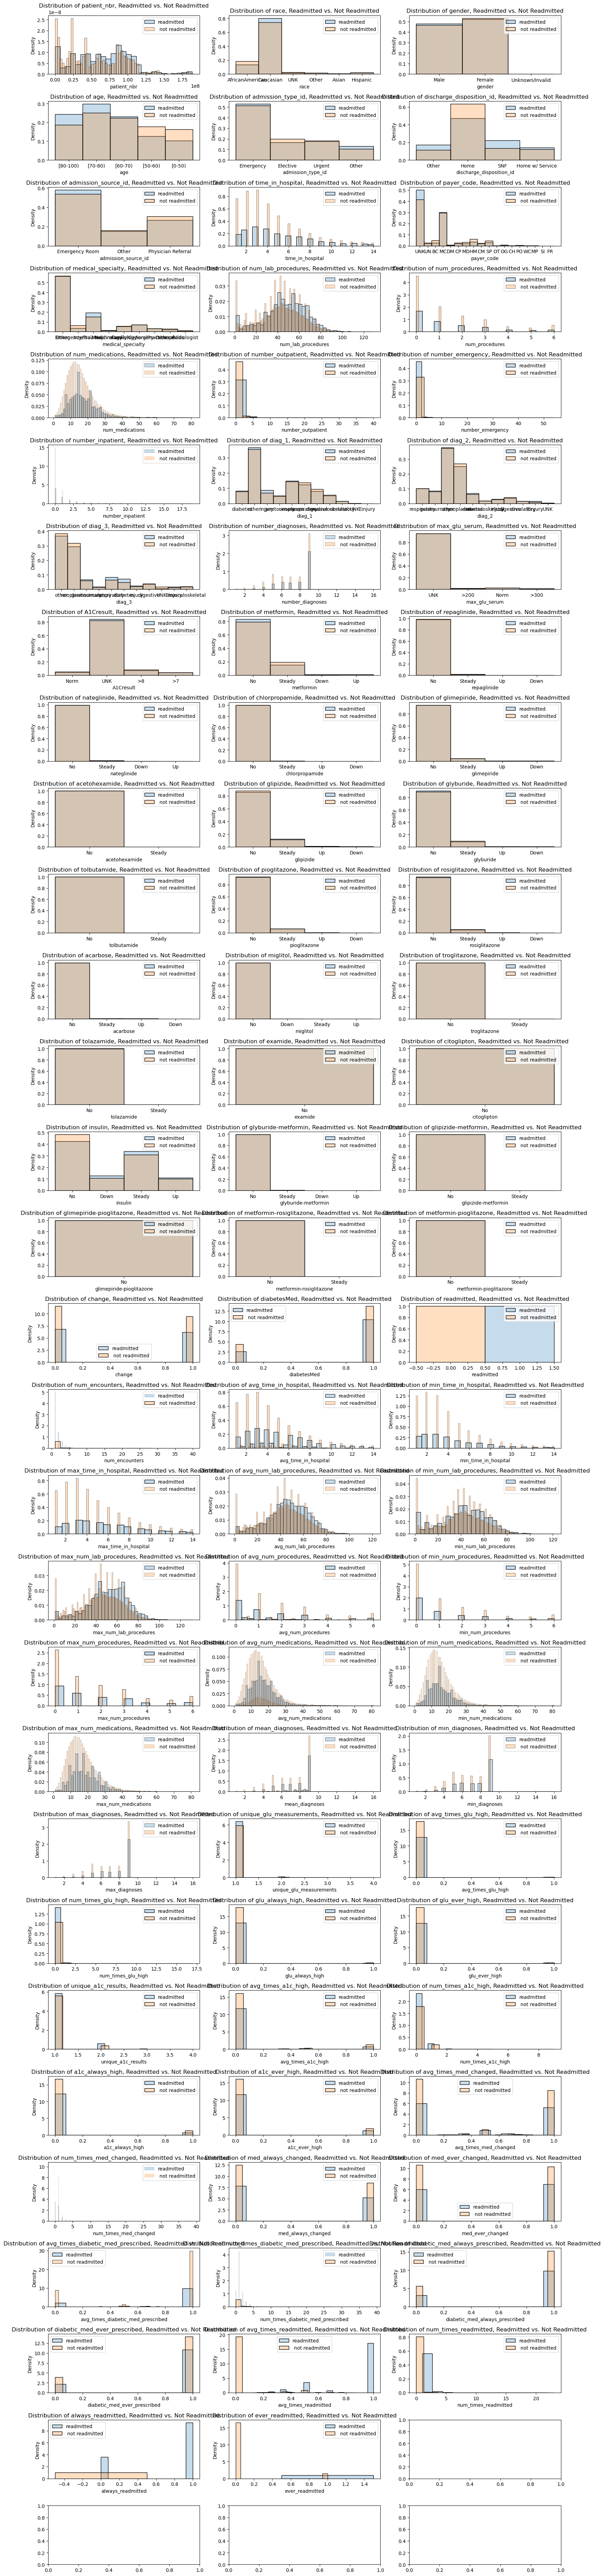

In [16]:
fig, axs = plt.subplots(30,3, figsize=(16, 75))
axs = axs.ravel()
omit = ['patient_nbr']
mask = df_patients['readmitted'] == 1

for i,col in enumerate(df_patients.columns):
    sns.histplot(df_patients[col][mask], ax=axs[i], alpha=0.25, label='readmitted', stat='density')
    sns.histplot(df_patients[col][~mask], ax=axs[i], alpha=0.25, label=' not readmitted', stat='density')
    axs[i].legend()
    axs[i].set_title(f'Distribution of {col}, Readmitted vs. Not Readmitted')
plt.tight_layout()

In [17]:
non_drug_features = ['patient_nbr', 'race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'payer_code', 'medical_specialty', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'change', 'diabetesMed']

drug_features = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone','tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone']

derived_features = ['num_encounters', 'avg_time_in_hospital', 'min_time_in_hospital',
       'max_time_in_hospital', 'avg_num_lab_procedures',
       'min_num_lab_procedures', 'max_num_lab_procedures',
       'avg_num_procedures', 'min_num_procedures', 'max_num_procedures',
       'avg_num_medications', 'min_num_medications', 'max_num_medications',
       'mean_diagnoses', 'min_diagnoses', 'max_diagnoses',
       'unique_glu_measurements', 'avg_times_glu_high', 'num_times_glu_high',
       'glu_always_high', 'glu_ever_high', 'unique_a1c_results',
       'avg_times_a1c_high', 'num_times_a1c_high', 'a1c_always_high',
       'a1c_ever_high', 'avg_times_med_changed', 'num_times_med_changed',
       'med_always_changed', 'med_ever_changed',
       'avg_times_diabetic_med_prescribed',
       'num_times_diabetic_med_prescribed', 'diabetic_med_always_prescribed',
       'diabetic_med_ever_prescribed', 'avg_times_readmitted',
       'num_times_readmitted', 'always_readmitted', 'ever_readmitted']

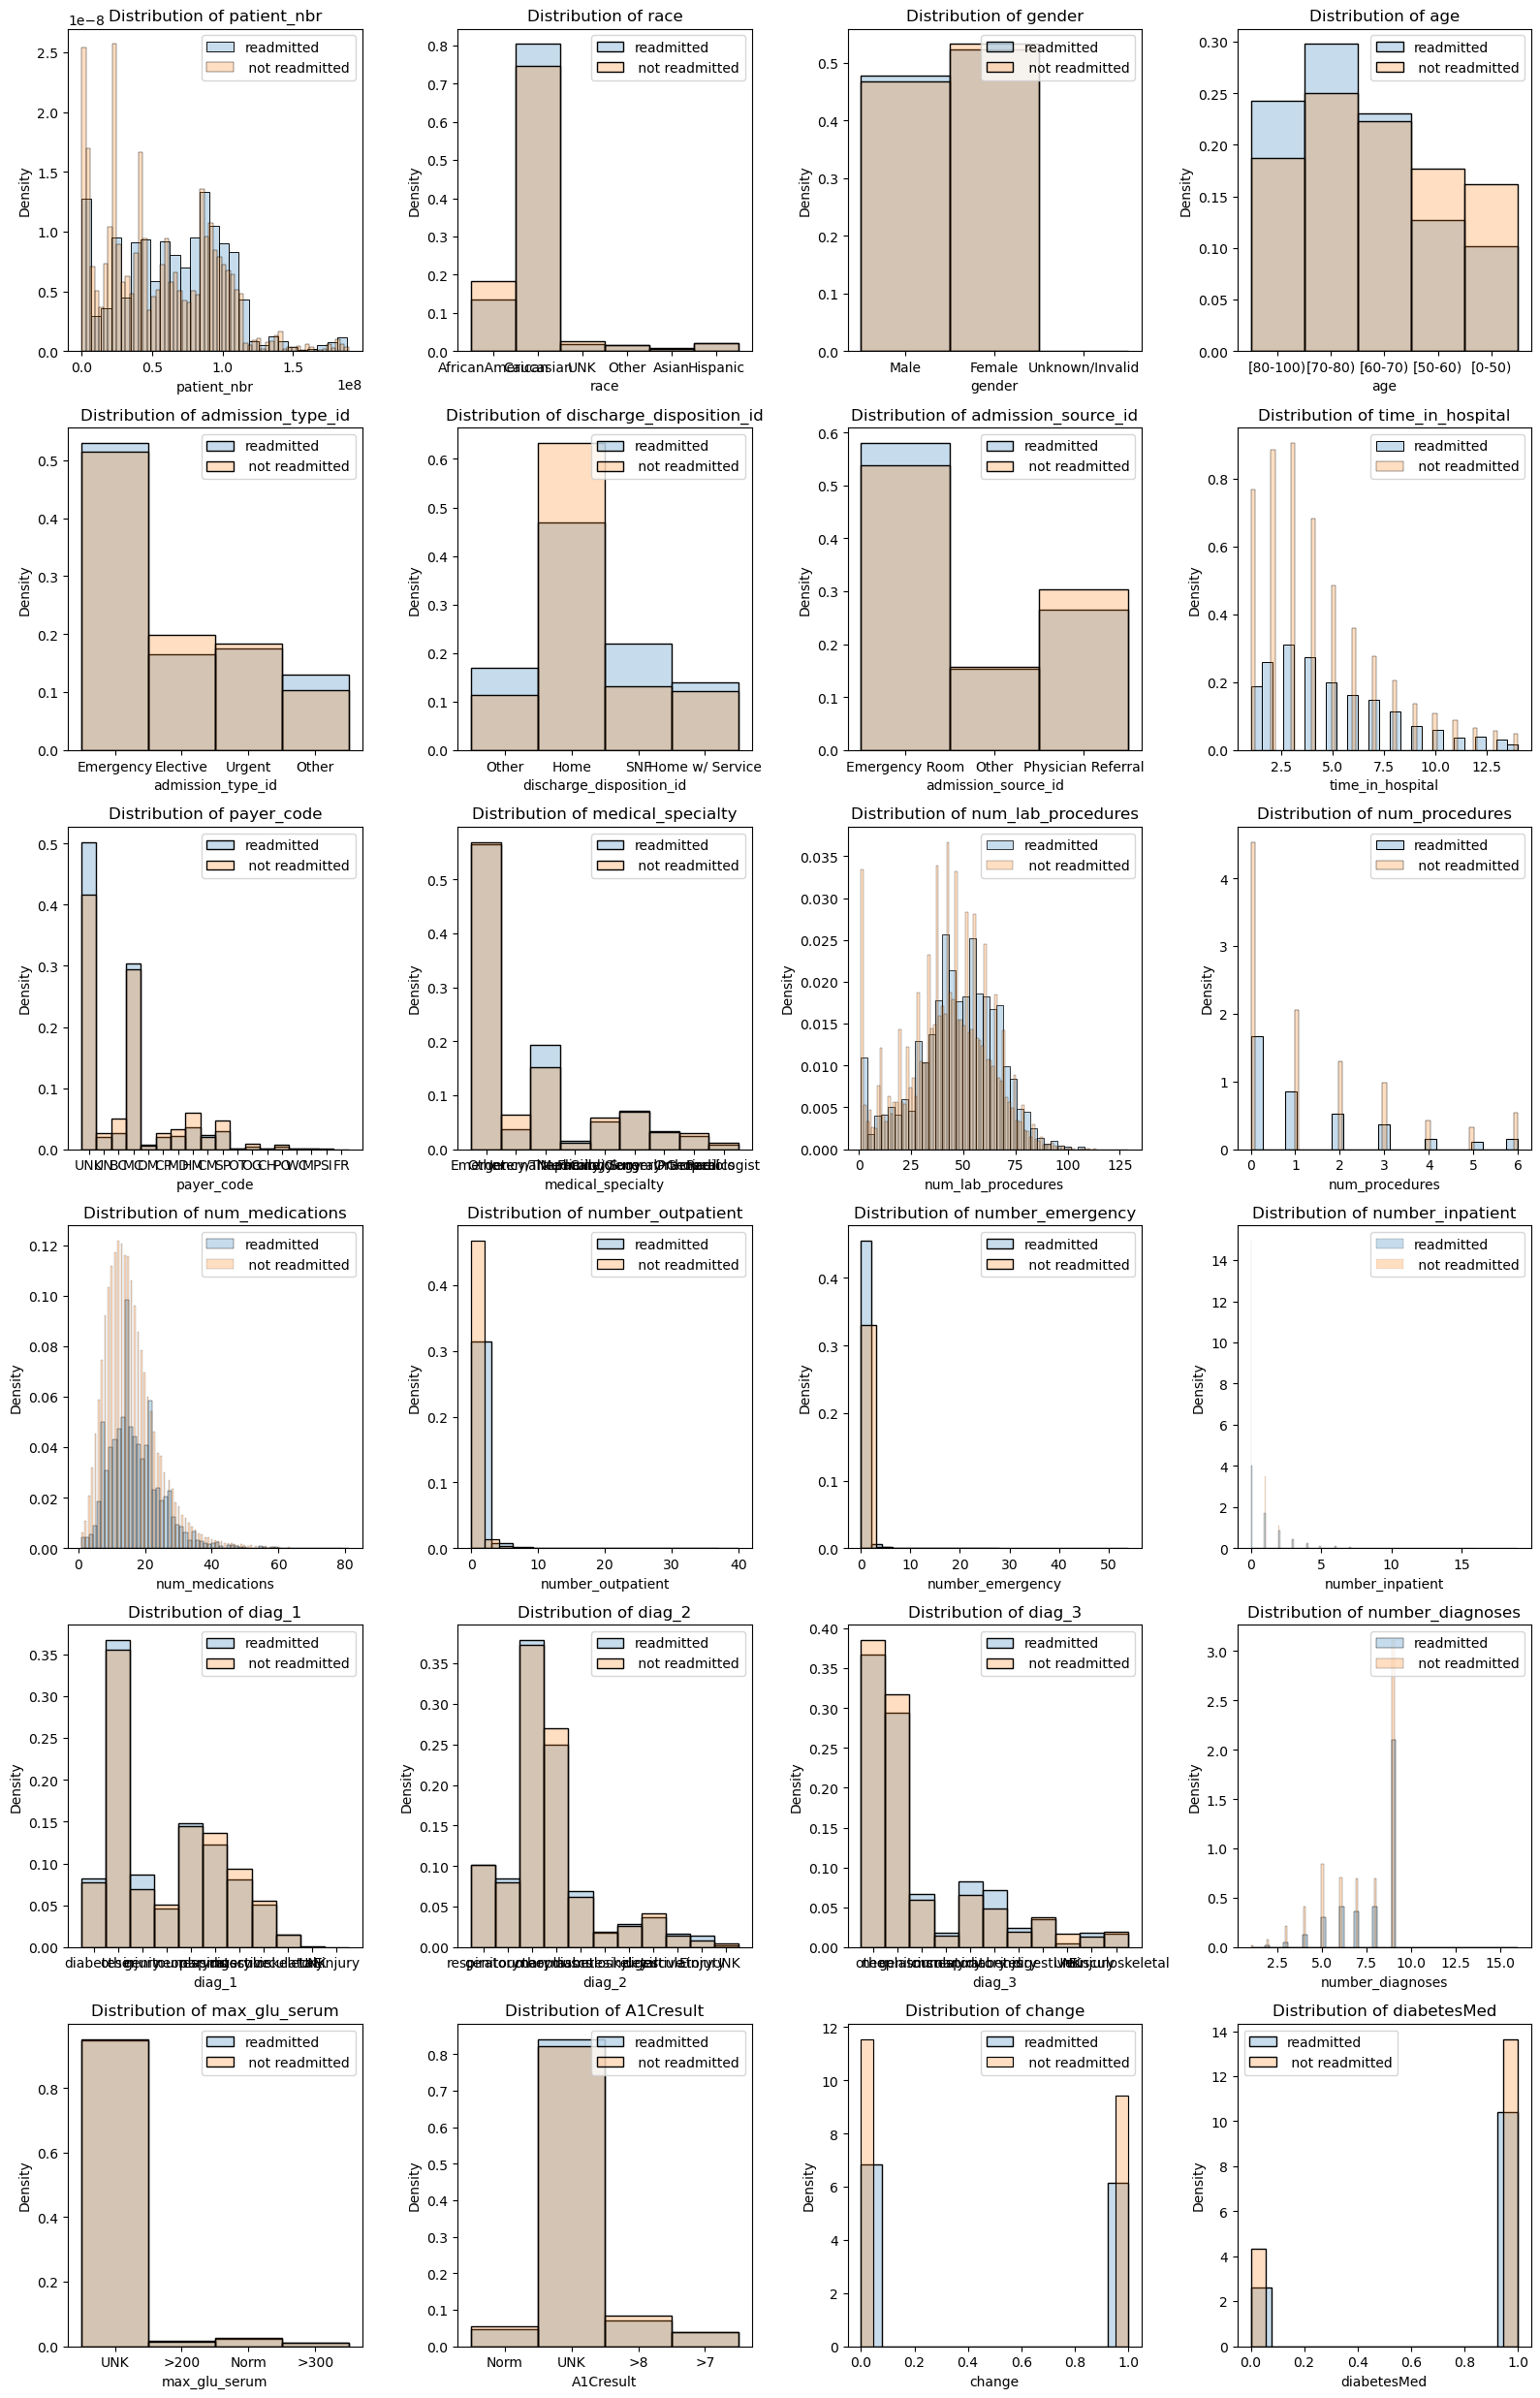

In [18]:
fig, axs = plt.subplots(6,4, figsize=(16, 25))
axs = axs.ravel()
mask = df_patients['readmitted'] == 1

for i,col in enumerate(non_drug_features):
    sns.histplot(df_patients[col][mask], ax=axs[i], alpha=0.25, label='readmitted', stat='density')
    sns.histplot(df_patients[col][~mask], ax=axs[i], alpha=0.25, label=' not readmitted', stat='density')
    axs[i].legend()
    axs[i].set_title(f'Distribution of {col}')
plt.tight_layout()

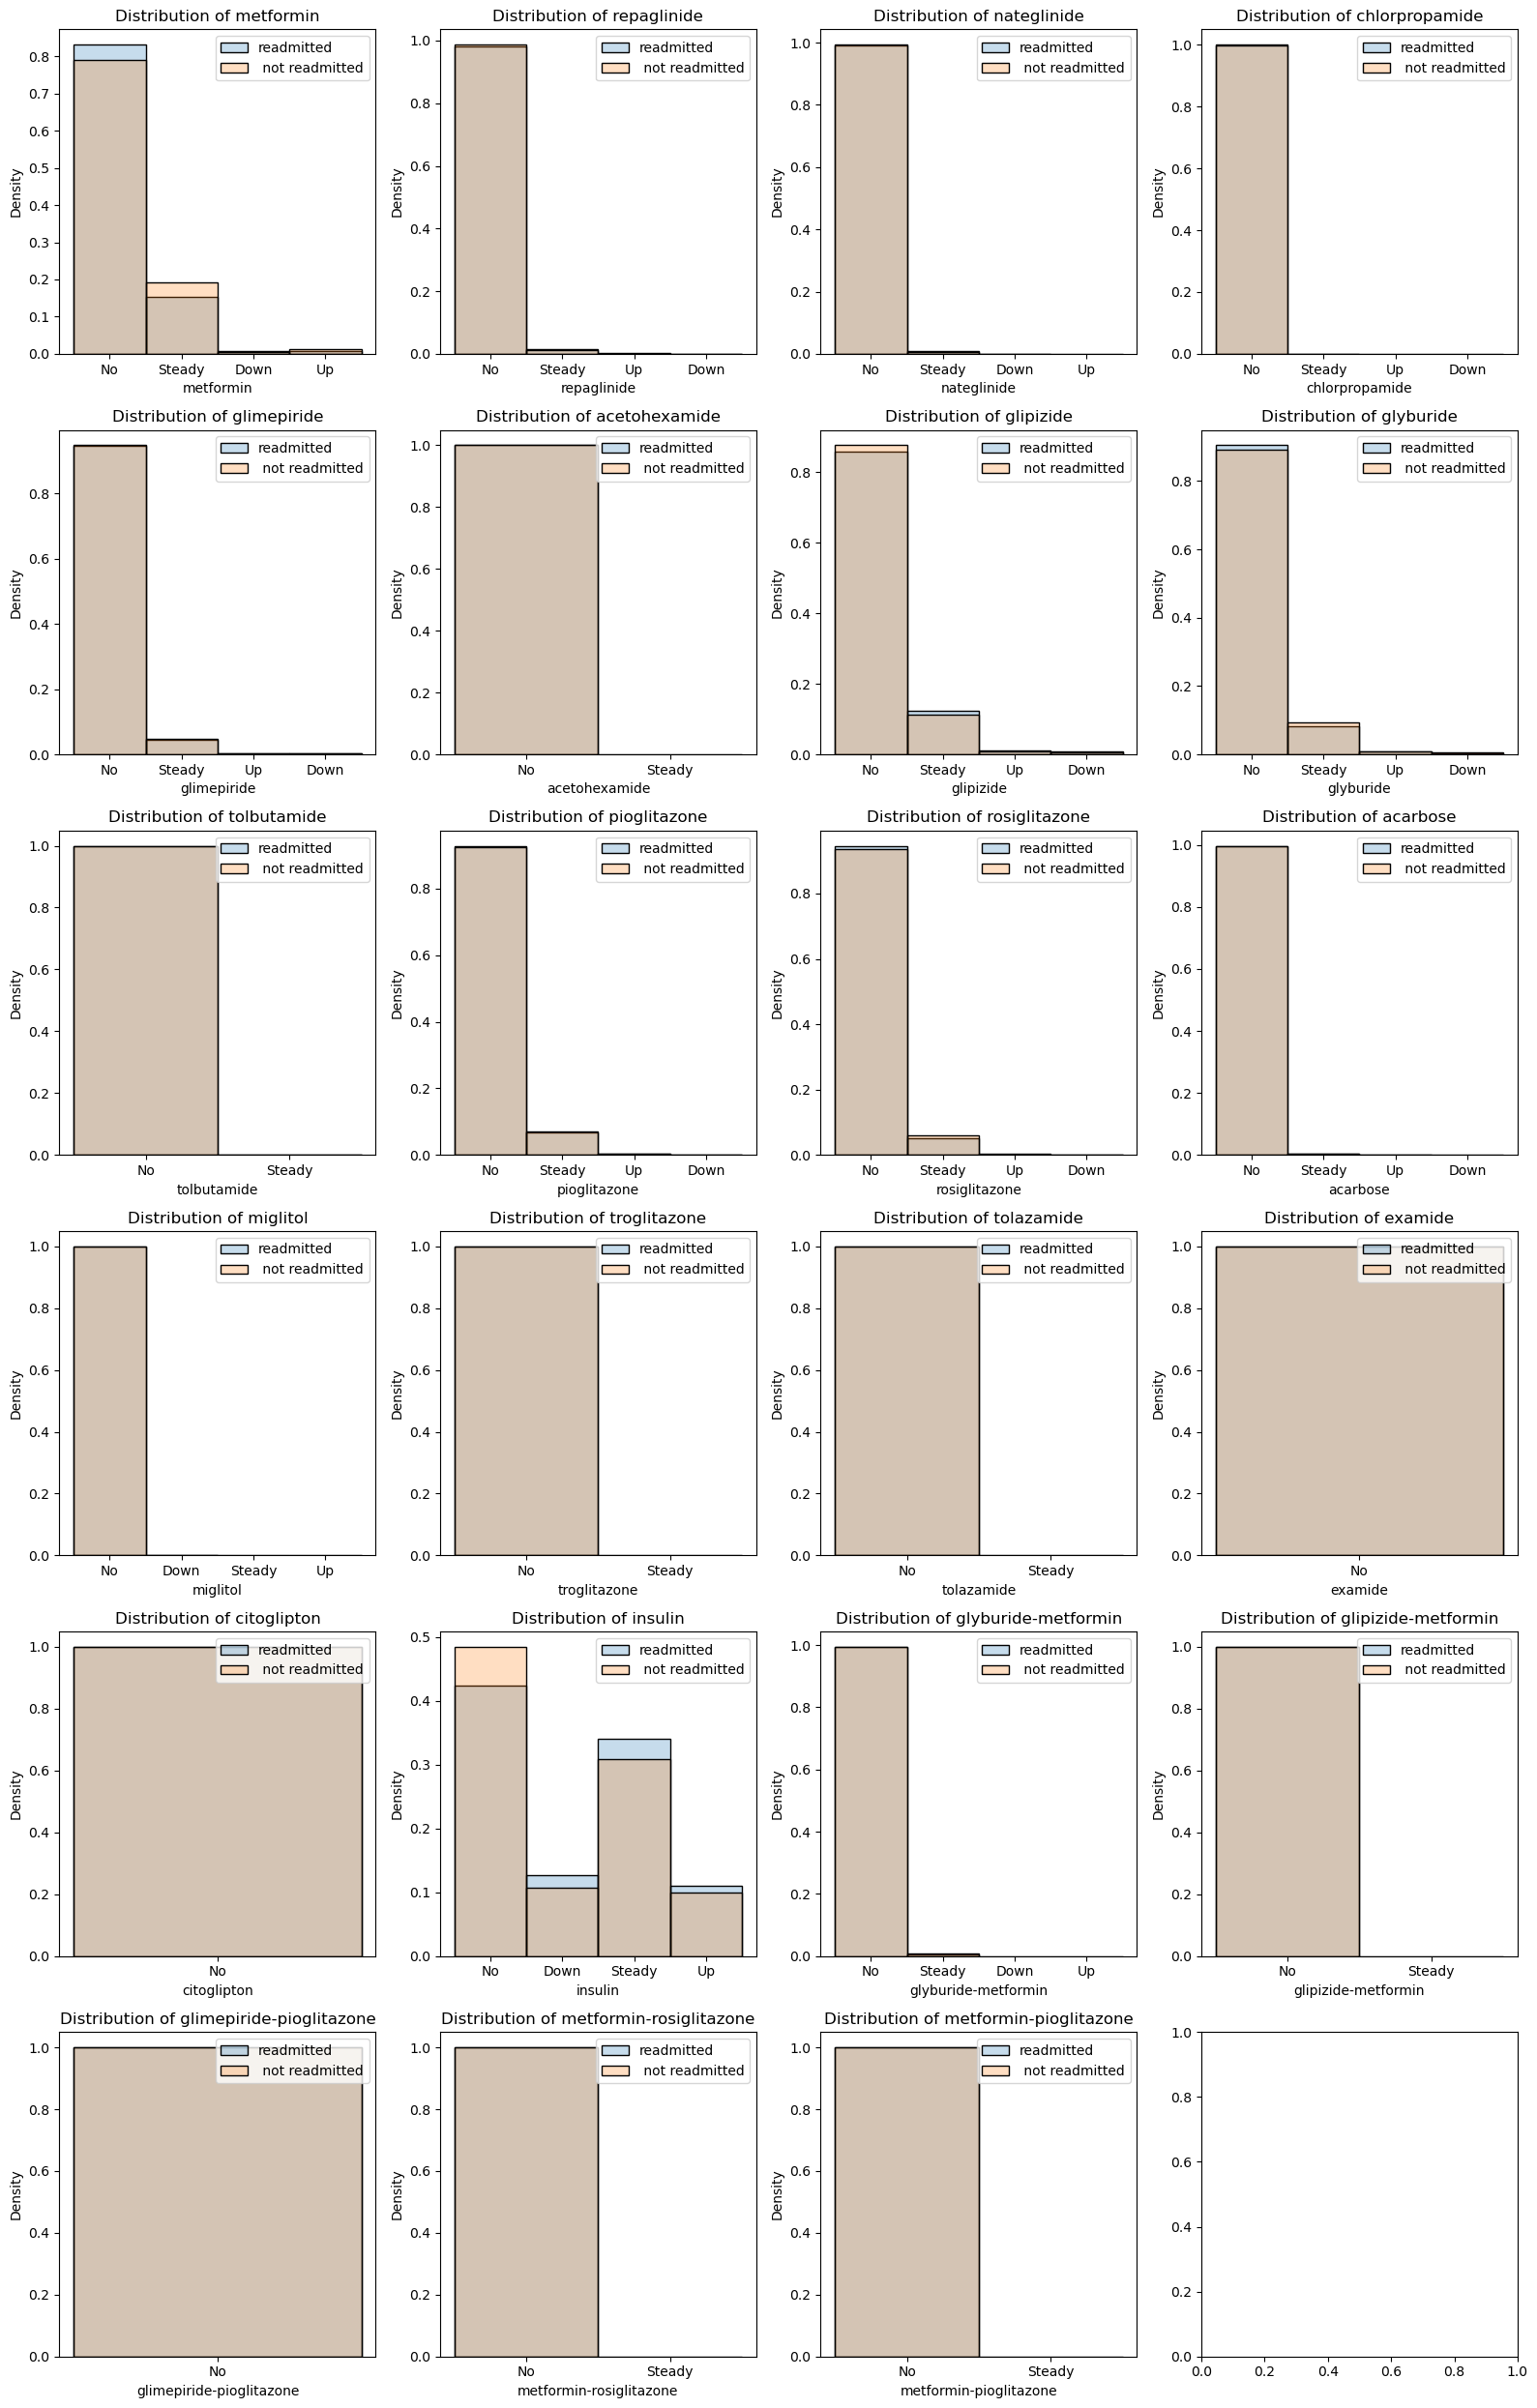

In [19]:
fig, axs = plt.subplots(6,4, figsize=(16, 25))
axs = axs.ravel()
mask = df_patients['readmitted'] == 1

for i,col in enumerate(drug_features):
    sns.histplot(df_patients[col][mask], ax=axs[i], alpha=0.25, label='readmitted', stat='density')
    sns.histplot(df_patients[col][~mask], ax=axs[i], alpha=0.25, label=' not readmitted', stat='density')
    axs[i].legend()
    axs[i].set_title(f'Distribution of {col}')
plt.tight_layout()

Text(0.5, 1.0, 'Distribution of Num_Lab_Procedures')

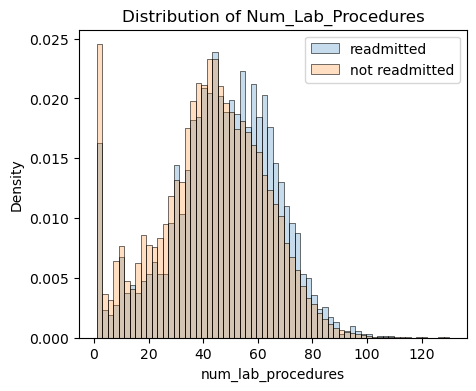

In [20]:
fig, ax = plt.subplots(1,1, figsize=(5, 4))
col = 'num_lab_procedures'
bins = np.linspace(1,130,65)
sns.histplot(df_patients[col][mask], ax=ax, alpha=0.25, label='readmitted', stat='density', bins=bins)
sns.histplot(df_patients[col][~mask], ax=ax, alpha=0.25, label='not readmitted', stat='density', bins=bins)
ax.legend()
ax.set_title('Distribution of Num_Lab_Procedures')

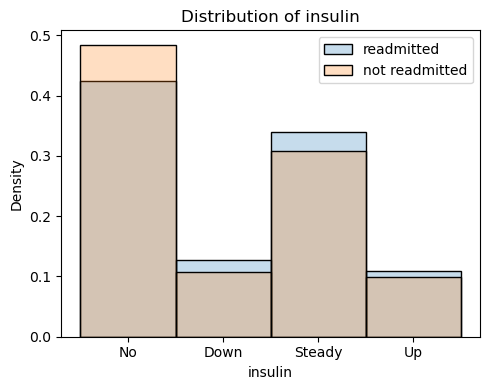

In [21]:
fig, axs = plt.subplots(1,1, figsize=(5, 4))
mask = df_patients['readmitted'] == 1
col='insulin'

sns.histplot(df_patients[col][mask], ax=axs, alpha=0.25, label='readmitted', stat='density')
sns.histplot(df_patients[col][~mask], ax=axs, alpha=0.25, label='not readmitted', stat='density')
axs.legend()
axs.set_title(f'Distribution of {col}')
plt.tight_layout()

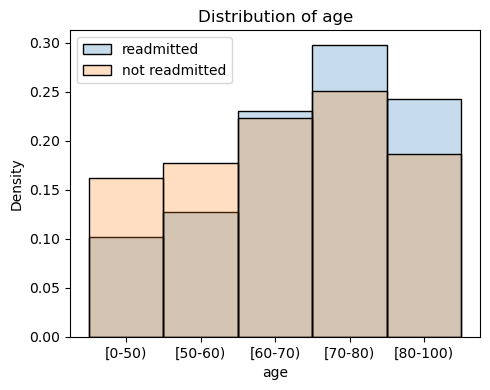

In [22]:
fig, axs = plt.subplots(1,1, figsize=(5, 4))
mask = df_patients['readmitted'] == 1
col='age'
bins = df_patients['age'].value_counts().sort_values().index.values
sns.histplot(x=df_patients[col][mask], ax=axs, alpha=0.25, label='readmitted', stat='density', bins=bins)
sns.histplot(x=df_patients[col][~mask], ax=axs, alpha=0.25, label='not readmitted', stat='density', bins=bins)
axs.legend()
axs.invert_xaxis()
axs.set_title(f'Distribution of {col}')
plt.tight_layout()

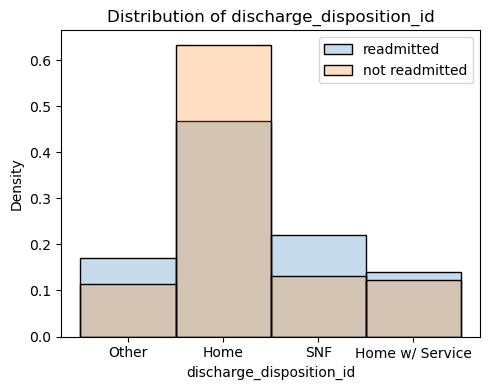

In [23]:
fig, axs = plt.subplots(1,1, figsize=(5, 4))
mask = df_patients['readmitted'] == 1
col='discharge_disposition_id'
bins = df_patients['age'].value_counts().sort_values().index.values
sns.histplot(x=df_patients[col][mask], ax=axs, alpha=0.25, label='readmitted', stat='density', bins=bins)
sns.histplot(x=df_patients[col][~mask], ax=axs, alpha=0.25, label='not readmitted', stat='density', bins=bins)
axs.legend()
axs.set_title(f'Distribution of {col}')
plt.tight_layout()

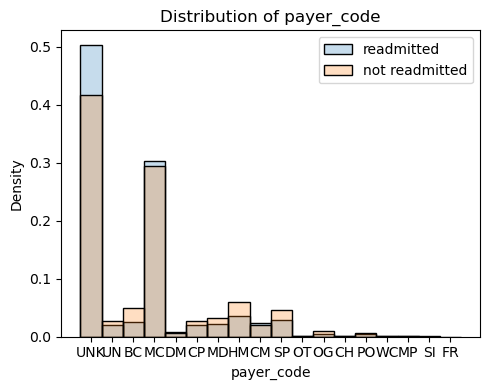

In [24]:
fig, axs = plt.subplots(1,1, figsize=(5, 4))
mask = df_patients['readmitted'] == 1
col='payer_code'
bins = df_patients['age'].value_counts().sort_values().index.values
sns.histplot(x=df_patients[col][mask], ax=axs, alpha=0.25, label='readmitted', stat='density', bins=bins)
sns.histplot(x=df_patients[col][~mask], ax=axs, alpha=0.25, label='not readmitted', stat='density', bins=bins)
axs.legend()
axs.set_title(f'Distribution of {col}')
plt.tight_layout()

### PCA

In [27]:
OHE = OneHotEncoder(sparse_output=False).fit(df_patients[object_cols])
ohe_data = OHE.transform(df_patients[object_cols])
ohe_df = pd.DataFrame(ohe_data, columns=OHE.get_feature_names_out())

In [28]:
scaler = StandardScaler().fit(df_patients[int64_cols + float64_cols])
scaled_numeric = scaler.transform(df_patients[int64_cols + float64_cols])
scaled_numeric_df = pd.DataFrame(scaled_numeric, columns=scaler.get_feature_names_out())
scaled_numeric_df = scaled_numeric_df.drop(['patient_nbr'], axis=1)

In [29]:
pca_quant = PCA().fit_transform(scaled_numeric_df)

Text(0.5, 1.0, 'PCA on Readmitted Patients, Quantitative Features')

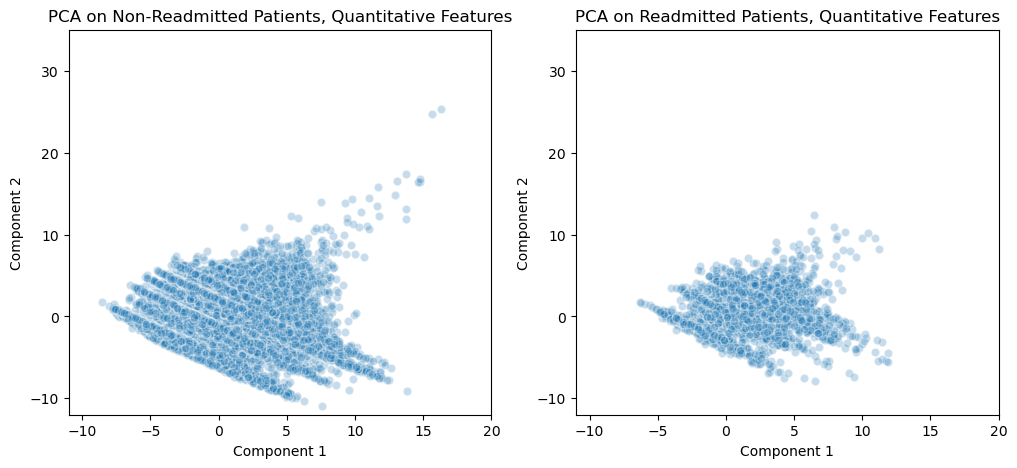

In [50]:
fig, axs = plt.subplots(1,2, figsize=(12,5))
xlims = [-11, 20]
ylims = [-12, 35]
axs[0].scatter(pca_quant[~mask,0], pca_quant[~mask,1], alpha=0.25, edgecolor='w')
axs[1].scatter(pca_quant[mask,0], pca_quant[mask,1], alpha=0.25, edgecolor='w')
mask = df_patients.readmitted == 1

for ax in axs.ravel():
    ax.set_xlim(xlims)
    ax.set_xlabel('Component 1')
    ax.set_ylim(ylims)
    ax.set_ylabel("Component 2")

axs[0].set_title('PCA on Non-Readmitted Patients, Quantitative Features')
axs[1].set_title('PCA on Readmitted Patients, Quantitative Features');

<a name="2.5.-Summary-of-EDA-Key-Findings"></a>
## 2.5 Summary of EDA Key Findings

[Return to top](#Notebook-Contents)

After inspecting the data, performing preprocessing, and exploratory data analysis, we summarize our main findings here:

1. Placeholder1
2. Placeholder2
3. Placeholder2

<a name="3.-Research-Questions"></a>
# 3. Research Questions

[Return to top](#Notebook-Contents)

After initial exploration and cleaning of the data, we have focused our efforts on answering the following research questions:

1. **How likely are patients to be readmitted to hospital within 30 days of discharge?**

2. **What risk factors drive early readmittance (within 30 days of discharge) to hospital?**

Answering these questions will help medical personnel prioritize follow-ups and interventions through the creation of patient risk profiles, which can identify patients at the highest risk level for early hospital readmittance. This information is actionable and can be used to mitigate negative health outcomes for these patients as well as increased costs for the hospital and insurance carrier.

Here we load the images from the train, validation, and test sets into 3 separate TF datasets.

Here we combine the image and label TF datasets, by zipping them together to form 3 new TF datasets with both image and label information.

<a name="4.-Modeling-Pipeline-and-Training"></a>
# 4. Modeling Pipeline and Training

[Return to top](#Notebook-Contents)

<a name="4.1.-Candidate-Models"></a>
## 4.1 Candidate Models

[Return to top](#Notebook-Contents)

Moving on from our non-regularized logistic regression base model, we identified four candidate models that we used to try to achieve higher performance for this classification task:

1. Lasso Logistic Regression
2. Single Decision Tree
3. Random Forest
4. Gradient Boosting

These models were selected to span the major classes of classification model we have been exposed to in CS109A.

<a name="4.2.-Model-Performance-Assessment"></a>
## 4.2 Model Performance Assessment

[Return to top](#Notebook-Contents)

We assessed model performance during hyperparameter training using 10-fold cross-validation on the training set, with the Area Under the Receiver Operating Characteristic curve (AUC-ROC) as our performance metric, since this metric is relatively invariant to class imbalance. 

To assess tuned model performance on the full training and test set, we again used AUC-ROC and supplemented with five additional metrics: 

1. **AUC-ROC:** Area Under the Receiver Operating Characteristic curve measures the model’s ability to distinguish between positive and negative cases.
2. **AUC-PR:** Area Under the Precision-Recall curve measures the model’s performance across the entire spectrum of Precision-Recall thresholds.
3. **F1-Score:** creates a balance between precision and recall by using their harmonic mean.
4. **Sensitivity-Recall:** the proportion of actual positive cases correctly identified by a model.
5. **Specificity:** the proportion of actual negative cases correctly identified by a model.
6. **Precision:** the proportion of true positives among all positive predictions made by the model.

We focused more on the metrics of AUC-ROC and AUC-PR since they are not subject to the arbitrary choice of a threshold value and are more informative performance metrics when significant class imbalance is present in the data.

<a name="4.3.-Feature-Engineering"></a>
## 4.3 Feature Engineering

[Return to top](#Notebook-Contents)

In this section, we performed additional feature engineering steps that go beyond the previous preprocessing of the data. These steps include:

1. Removing features that have a pairwise correlation greater than 0.85.
2. Removing features that have cardinality greater than 10.
3. Transforming some continuous variables to the logarithmic scale.
4. Standardizing continuous variables.
5. One-hot encoding categorical variables.

These steps were efficiently acheived using an `sklearn pipeline`, so that we could fit and transform the steps on the training data and then use the same process to transform the test data.

In [64]:
# get lists of qualitative and quantitative column names
qual_cols = [cname for cname in X_train.columns if X_train[cname].dtype == "object"]
quant_cols = [cname for cname in X_train.columns if X_train[cname].dtype != "object"]

In [67]:
# custom transformer code based on A. Geron Book by O'Reilly 
class PrepQuant(BaseEstimator, TransformerMixin):
    
    def __init__(self, corr_threshold=0.85, cardinality_threshold=10):
        self.corr_threshold=corr_threshold
        self.cardinality_threshold=cardinality_threshold
    
    def fit(self, X, y=None):
        #source: stackoverflow
        corr_matrix = X.corr().abs()
        # Select upper triangle of correlation matrix
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        self.corr_cols = [column for column in upper.columns if any(upper[column] >= self.corr_threshold)] 
        
        self.high_cardinal_cols = [col for col in X.columns if X[col].nunique()>self.cardinality_threshold]
        
        return self
    
    def transform(self, X):
            
        X.drop(self.corr_cols, axis=1, inplace=True)
        
        #log Transformation is done here not because Logistic Regression
        #depends on it but to reduce the effects of outliers
        for col in X.columns:
            if col in self.high_cardinal_cols:
                X['log_'+col]=np.log1p(X[col])
                X.drop(col,axis=1,inplace=True)
        self.columns = X.columns
        return X
                
    def get_feature_names_out(self, *args, **params):
        return self.columns

In [81]:
# create the feature engineering pipeline
quant_pipeline = make_pipeline(PrepQuant(), StandardScaler())
ct = ColumnTransformer([('ohe',OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'),
                         qual_cols),
                       ('quant',quant_pipeline,quant_cols)])

# convert pipeline output to a dataframe
ct.set_output(transform='pandas')

# fit and transform on the training data
X_train_transformed = ct.fit_transform(X_train)
print(f'Transformed training data dimensions: {X_train_transformed.shape}')

# transform the testing data
X_test_transformed = ct.transform(X_test)
print(f'Transformed testing data dimensions: {X_test_transformed.shape}')

Transformed training data dimensions: (55992, 135)
Transformed testing data dimensions: (13998, 135)


In [70]:
# inspect training data dtypes
pd.set_option('display.max_rows', None)
display(X_train_transformed.dtypes)

ohe__race_Asian                                  float64
ohe__race_Caucasian                              float64
ohe__race_Hispanic                               float64
ohe__race_Other                                  float64
ohe__race_UNK                                    float64
ohe__gender_Male                                 float64
ohe__gender_Unknown/Invalid                      float64
ohe__age_[50-60)                                 float64
ohe__age_[60-70)                                 float64
ohe__age_[70-80)                                 float64
ohe__age_[80-100)                                float64
ohe__admission_type_id_Emergency                 float64
ohe__admission_type_id_Other                     float64
ohe__admission_type_id_Urgent                    float64
ohe__discharge_disposition_id_Home w/ Service    float64
ohe__discharge_disposition_id_Other              float64
ohe__discharge_disposition_id_SNF                float64
ohe__admission_source_id_Other 

In [71]:
# inspect training data variables
X_train_transformed.describe()

ohe__race_Asian  ohe__race_Caucasian  ohe__race_Hispanic  \
count        55992.000            55992.000           55992.000   
mean             0.007                0.747               0.021   
std              0.085                0.434               0.145   
min              0.000                0.000               0.000   
25%              0.000                0.000               0.000   
50%              0.000                1.000               0.000   
75%              0.000                1.000               0.000   
max              1.000                1.000               1.000   

       ohe__race_Other  ohe__race_UNK  ohe__gender_Male  \
count        55992.000      55992.000         55992.000   
mean             0.016          0.027             0.468   
std              0.126          0.161             0.499   
min              0.000          0.000             0.000   
25%              0.000          0.000             0.000   
50%              0.000          0.000             0.000   
75%              0.000          0.000             1.000   
max              1.000          1.000             1.000   

       ohe__gender_Unknown/Invalid  ohe__age_[50-60)  ohe__age_[60-70)  \
count                    5.599e+04         55992.000         55992.000   
mean                     5.358e-05             0.175             0.222   
std                      7.320e-03             0.380             0.416   
min                      0.000e+00             0.000             0.000   
25%                      0.000e+00             0.000             0.000   
50%                      0.000e+00             0.000             0.000   
75%                      0.000e+00             0.000             0.000   
max                      1.000e+00             1.000             1.000   

       ohe__age_[70-80)  ohe__age_[80-100)  ohe__admission_type_id_Emergency  \
count         55992.000          55992.000                         55992.000   
mean              0.253              0.189                             0.516   
std               0.435              0.392                             0.500   
min               0.000              0.000                             0.000   
25%               0.000              0.000                             0.000   
50%               0.000              0.000                             1.000   
75%               1.000              0.000                             1.000   
max               1.000              1.000                             1.000   

       ohe__admission_type_id_Other  ohe__admission_type_id_Urgent  \
count                     55992.000                      55992.000   
mean                          0.105                          0.183   
std                           0.307                          0.387   
min                           0.000                          0.000   
25%                           0.000                          0.000   
50%                           0.000                          0.000   
75%                           0.000                          0.000   
max                           1.000                          1.000   

       ohe__discharge_disposition_id_Home w/ Service  \
count                                      55992.000   
mean                                           0.123   
std                                            0.328   
min                                            0.000   
25%                                            0.000   
50%                                            0.000   
75%                                            0.000   
max                                            1.000   

       ohe__discharge_disposition_id_Other  ohe__discharge_disposition_id_SNF  \
count                            55992.000                          55992.000   
mean                                 0.116                              0.137   
std                                  0.321                              0.343   
min                    

<a name="4.4.-Base-Model"></a>
## 4.4 Base Model

[Return to top](#Notebook-Contents)

Here we fitted our base model - a non-regularized logistic regression model without any hyperparameter tuning - and assessed its performance.

In [78]:
start_time = time.time()

base_model = LogisticRegression(
    penalty=None, 
    C=1.0, 
    max_iter=10000, 
    random_state=109
).fit(X_train_transformed, y_train)

end_time = time.time()
print(f"Model fitting time: {end_time - start_time:.1f} seconds")

Model fitting time: 9.60 seconds


In [79]:
def print_stats(dataset_type, model, X, y):
    y_pred_prob = model.predict_proba(X)[:,1]
    print(f'------------------{dataset_type}----------------------')
    print(f'Readmitted Rate:\tActual:{np.round(np.mean(y),4)}\tPredicted:{np.round(np.mean(y_pred_prob),4)}')
    print(f'Accuracy:\t\tNaive:{np.round(1-np.mean(y),3)}\tBase Model:{np.round(model.score(X,y),3)}')
    print(f'AUC:\t\t\t{np.round(roc_auc_score(y, y_pred_prob),3)}')
    
print_stats('TRAIN', base_model, X_train_transformed, y_train)

------------------TRAIN----------------------
Readmitted Rate:	Actual:0.0496	Predicted:0.0496
Accuracy:		Naive:0.95	Base Model:0.95
AUC:			0.712


In [82]:
print_stats('TEST', base_model, X_test_transformed, y_test)

------------------TEST----------------------
Readmitted Rate:	Actual:0.0496	Predicted:0.0502
Accuracy:		Naive:0.95	Base Model:0.95
AUC:			0.682


In [83]:
start_time = time.time()

base_model_balanced = LogisticRegression(
    penalty=None, 
    C=1.0,
    max_iter=10000, 
    random_state=109,
    class_weight='balanced'
).fit(X_train_transformed, y_train)

end_time = time.time()
print(f"Model fitting time: {end_time - start_time:.1f} seconds")

Model fitting time: 11.5 seconds


In [84]:
print_stats('TRAIN - Balanced', base_model_balanced, X_train_transformed, y_train)
print_stats('TEST  - Balanced', base_model_balanced, X_test_transformed, y_test)

------------------TRAIN - Balanced----------------------
Readmitted Rate:	Actual:0.0496	Predicted:0.4366
Accuracy:		Naive:0.95	Base Model:0.673
AUC:			0.717
------------------TEST  - Balanced----------------------
Readmitted Rate:	Actual:0.0496	Predicted:0.4367
Accuracy:		Naive:0.95	Base Model:0.668
AUC:			0.684


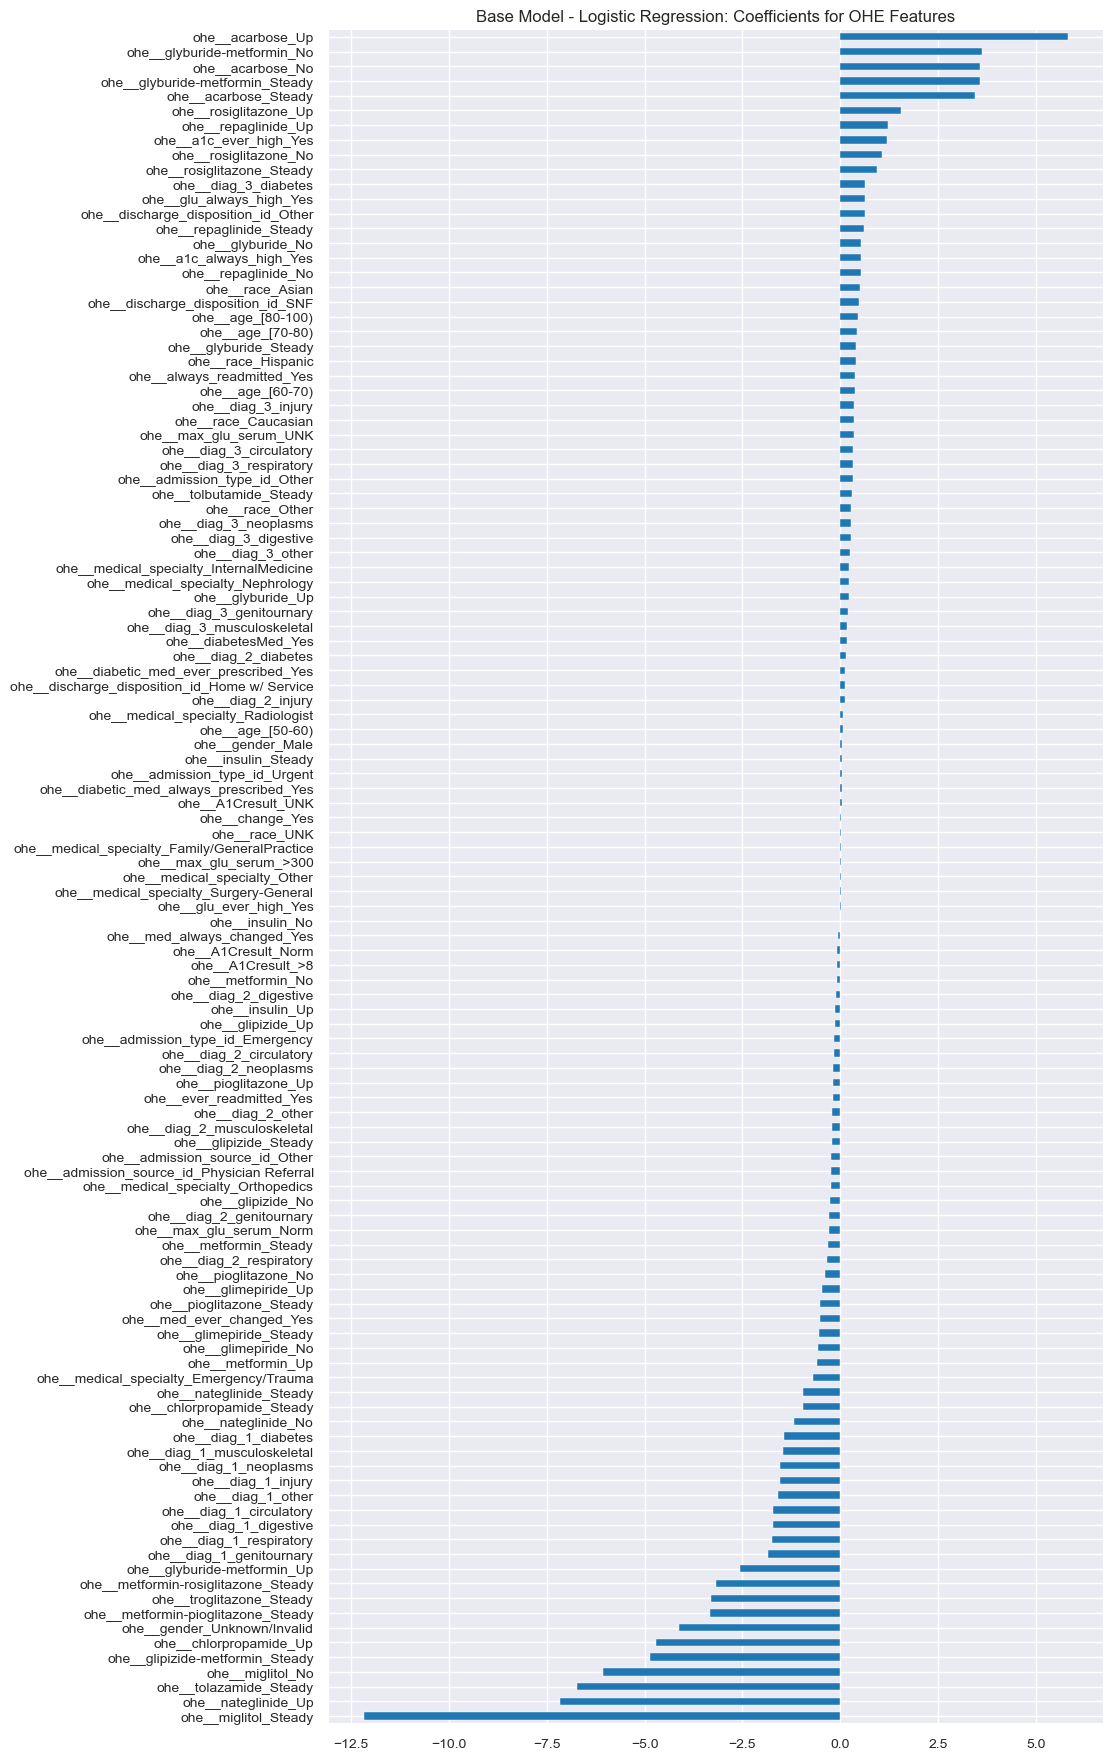

In [93]:
ohe_features = [feature for feature in base_model.feature_names_in_ if feature.startswith('ohe__')]
ohe_coefs    = [coef for feature,coef in zip(base_model.feature_names_in_,base_model.coef_.ravel())
                                             if feature.startswith('ohe__')]

quant_features = [feature for feature in base_model.feature_names_in_ if feature.startswith('quant__')]
quant_coefs    = [coef for feature,coef in zip(base_model.feature_names_in_,base_model.coef_.ravel())
                                             if feature.startswith('quant__')]

plt.figure(figsize=(10,22))
coef = pd.Series(ohe_coefs, index=ohe_features)
_ = coef.sort_values().plot.barh().set_title('Base Model - Logistic Regression: Coefficients for OHE Features')

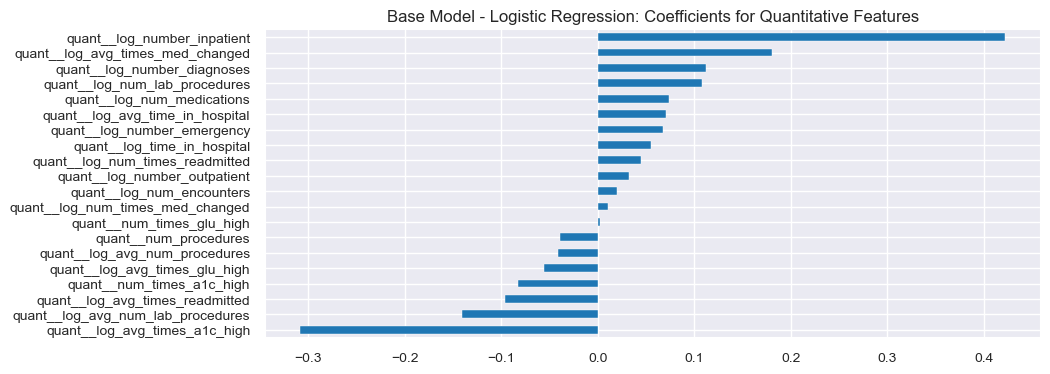

In [91]:
plt.figure(figsize=(10,4))
coef = pd.Series(quant_coefs, index=quant_features)
_ = coef.sort_values().plot.barh().set_title('Base Model - Logistic Regression: Coefficients for Quantitative Features')

### Base Model Results Interpretation

The train and test accuracies are both 95%, same as the accuracy of naive model which always outputs the majority class.

The base model Logistic Regression results in a test AUC of 0.682; the train AUC is higher at 0.717, indicating some overfitting, which regularization may help reduce.

Calibration: As a secondary metric, we are also intrested in whether the actual predicted probabilities output by the model make sense.  Note that the model without any class weights adjustment is reasonably well calibrated on the test set: average readmitted rate is 0.0502 predicted vs. 0.0496 actual. Model with balanced class weights however is (expectedly) not well calibrated: average readmitted rate now jumps up to 0.4368 on test vs. again actual of 0.0496, with only a marginal gain in test AUC: 0.684 (balanced) vs. 0.682 (unbalanced).

Coefficient Interpretation:
Most important variables in Logistic Regression are the ones with the highest absolute value of coefficients.  The top variables are dominated by changes in dosages of various medications such as miglitol (most important), nateglinide, and others.   Primary diagnosis (reflected as diag1) also seems to be an important predictor.  The derived variable (a1c_ever_high) that measures an important blood test result of A1C for diabetic patients is also important.

<a name="4.5.-Candidate-Model-Training"></a>
## 4.5 Candidate Model Training

[Return to top](#Notebook-Contents)

We have set up a model training and assessment pipeline using simulated data (for the time being). Our next step will be to fit the following models with our actual data.

In [ ]:
# save metrics for base model
data = (X_train_transformed, X_test_transformed, y_train, y_test)
results = [get_performance_metrics(base_model, 'Base Model', data)]
get_results_df(results, model='Base Model')

In [2]:
####################################
########## SIMULATED DATA ##########
####################################

from sklearn import datasets

random_state = 109

# create dataset for binary classification with 5 predictors
X, y = datasets.make_classification(
    n_samples=1000,
    n_features=5,
    n_informative=3,
    n_redundant=2,
    random_state=random_state
)

# split into training and test
X_train_transformed, X_test, y_train_transformed, y_test = train_test_split(
    X, y,
    train_size=0.8,
    random_state=random_state
)

In [166]:
# Lasso Logistic Regression

start_time = time.time()

# C values to try 
Cs = [1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]

# logistic regression model with elasticnet penalty and 10-fold CV
lrr = LogisticRegressionCV(
    Cs=Cs, cv=10, penalty='elasticnet', solver='saga', n_jobs=-1, # solver='liblinear' for l1
    scoring='roc_auc', max_iter=1000, random_state=109, l1_ratios=[0, 0.5, 1],
).fit(X_train_transformed, y_train)

end_time = time.time()
print(f"Model fitting time: {end_time - start_time:.1f} seconds")

Model fitting time: 140.9 seconds


In [215]:
# save metrics for logistic regularized
data = (X_train_transformed, X_test_transformed, y_train, y_test)
results.append(get_performance_metrics(lrr, 'Logistic Regularized', data))
get_results_df(results, model='Logistic Regularized')

model partition                     metric  value
1   Logistic Regularized     Train   Readmitted-Rate-Observed    5.0
3   Logistic Regularized     Train  Readmitted-Rate-Predicted    5.0
5   Logistic Regularized     Train             Naive-Accuracy   95.0
7   Logistic Regularized     Train                   Accuracy   95.0
9   Logistic Regularized     Train                    AUC-ROC   70.7
11  Logistic Regularized     Train                     AUC-PR   12.5
13  Logistic Regularized     Train                   F1-Score    0.1
15  Logistic Regularized     Train         Recall-Sensitivity    0.0
17  Logistic Regularized     Train                Specificity  100.0
19  Logistic Regularized     Train                  Precision  100.0
21  Logistic Regularized      Test   Readmitted-Rate-Observed    5.0
23  Logistic Regularized      Test  Readmitted-Rate-Predicted    5.0
25  Logistic Regularized      Test             Naive-Accuracy   95.0
27  Logistic Regularized      Test                   Accuracy   95.0
29  Logistic Regularized      Test                    AUC-ROC   67.8
31  Logistic Regularized      Test                     AUC-PR   10.7
33  Logistic Regularized      Test                   F1-Score    0.0
35  Logistic Regularized      Test         Recall-Sensitivity    0.0
37  Logistic Regularized      Test                Specificity  100.0
39  Logistic Regularized      Test                  Precision    0.0

In [102]:
# Single Decision Tree

start_time = time.time()

# hyperparameter tuning dictionary
params = {'random_state': [109], 
          'criterion': ['gini'], 
          'splitter': ['best'], 
          'max_depth': range(3, 5),
          'min_samples_split': range(2, 30),
          'min_samples_leaf': [1], 
          'min_weight_fraction_leaf': [0.0], 
          'max_features': [None], 
          'max_leaf_nodes': [None], 
          'min_impurity_decrease': [0.0], 
          'class_weight': ['balanced'],
          'ccp_alpha': [0.0]
         }

# 10-fold CV
dt = GridSearchCV(
    estimator=DecisionTreeClassifier(),
    param_grid=params,
    cv=10,
    scoring='roc_auc',
    return_train_score=True
).fit(X_train_transformed, y_train)

# refitting outside of GridSearchCV so that we can extract Variable Importances later
dt_tuned = DecisionTreeClassifier(
    max_depth=dt.best_params_['max_depth'],
    min_samples_split=dt.best_params_['min_samples_split'],
    random_state=109
).fit(X_train_transformed, y_train)

end_time = time.time()
print(f"Model fitting time: {end_time - start_time:.1f} seconds")

Model fitting time: 63.9 seconds


In [216]:
# save metrics for decision tree
data = (X_train_transformed, X_test_transformed, y_train, y_test)
results.append(get_performance_metrics(dt_tuned, 'Decision Tree', data))
get_results_df(results, model='Decision Tree')

model partition                     metric  value
2   Decision Tree     Train   Readmitted-Rate-Observed    5.0
5   Decision Tree     Train  Readmitted-Rate-Predicted    5.0
8   Decision Tree     Train             Naive-Accuracy   95.0
11  Decision Tree     Train                   Accuracy   95.1
14  Decision Tree     Train                    AUC-ROC   65.5
17  Decision Tree     Train                     AUC-PR   11.3
20  Decision Tree     Train                   F1-Score    0.8
23  Decision Tree     Train         Recall-Sensitivity    0.4
26  Decision Tree     Train                Specificity  100.0
29  Decision Tree     Train                  Precision   91.7
32  Decision Tree      Test   Readmitted-Rate-Observed    5.0
35  Decision Tree      Test  Readmitted-Rate-Predicted    5.0
38  Decision Tree      Test             Naive-Accuracy   95.0
41  Decision Tree      Test                   Accuracy   95.0
44  Decision Tree      Test                    AUC-ROC   63.0
47  Decision Tree      Test                     AUC-PR    9.8
50  Decision Tree      Test                   F1-Score    0.6
53  Decision Tree      Test         Recall-Sensitivity    0.3
56  Decision Tree      Test                Specificity  100.0
59  Decision Tree      Test                  Precision   50.0

In [104]:
# Random Forest

start_time = time.time()

# hyperparameter tuning dictionary
params = {'random_state': [109],
          'n_estimators': [100, 200],
          'criterion': ['gini'],
          'max_depth': [None],
          'min_samples_split': [2,5,10,20],
          'min_samples_leaf': [1],
          'min_weight_fraction_leaf': [0.0],
          'max_features': ['sqrt'],
          'max_leaf_nodes': [None], 
          'min_impurity_decrease': [0.0],
          'bootstrap': [True], 
          'oob_score': [False],
          'n_jobs': [-1],
          'warm_start': [True], 
          'class_weight': ['balanced'],
          'ccp_alpha': [0.0]
         }

# 10-fold CV
rf = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=params,
    cv=10,
    scoring='roc_auc',
    return_train_score=True
).fit(X_train_transformed, y_train)

# refitting outside of GridSearchCV so that we can extract Variable Importances later
rf_tuned = RandomForestClassifier(
    n_estimators=rf.best_params_['n_estimators'],
    min_samples_split=rf.best_params_['min_samples_split'],
    random_state=109
).fit(X_train_transformed, y_train)

end_time = time.time()
print(f"Model fitting time: {end_time - start_time:.1f} seconds")

Model fitting time: 78.3 seconds


In [217]:
# save metrics for random forest
data = (X_train_transformed, X_test_transformed, y_train, y_test)
results.append(get_performance_metrics(rf_tuned, 'Random Forest', data))
get_results_df(results, model='Random Forest')

model partition                     metric  value
3   Random Forest     Train   Readmitted-Rate-Observed    5.0
7   Random Forest     Train  Readmitted-Rate-Predicted    5.1
11  Random Forest     Train             Naive-Accuracy   95.0
15  Random Forest     Train                   Accuracy   95.1
19  Random Forest     Train                    AUC-ROC   99.6
23  Random Forest     Train                     AUC-PR   93.7
27  Random Forest     Train                   F1-Score    0.6
31  Random Forest     Train         Recall-Sensitivity    0.3
35  Random Forest     Train                Specificity  100.0
39  Random Forest     Train                  Precision  100.0
43  Random Forest      Test   Readmitted-Rate-Observed    5.0
47  Random Forest      Test  Readmitted-Rate-Predicted    5.2
51  Random Forest      Test             Naive-Accuracy   95.0
55  Random Forest      Test                   Accuracy   95.0
59  Random Forest      Test                    AUC-ROC   69.5
63  Random Forest      Test                     AUC-PR   12.2
67  Random Forest      Test                   F1-Score    0.0
71  Random Forest      Test         Recall-Sensitivity    0.0
75  Random Forest      Test                Specificity  100.0
79  Random Forest      Test                  Precision    0.0

In [111]:
# Gradient Boosting

start_time = time.time()

# hyperparameter tuning dictionary
params = {'random_state': [109],
          'learning_rate': [0.01,0.1,1],
          'n_estimators': [50,100,250],
          'min_samples_split': [2], 
          'min_samples_leaf': [1], 
          'min_weight_fraction_leaf': [0.0], 
          'max_depth': [3], 
          'min_impurity_decrease': [0.0], 
          'max_features': [None], 
          'max_leaf_nodes': [None], 
          'warm_start': [True],
          'validation_fraction': [0.1], 
          'n_iter_no_change': [10],
          'ccp_alpha': [0.0]
         }

# 10-fold CV
gb = GridSearchCV(
    estimator=GradientBoostingClassifier(),
    param_grid=params,
    cv=10,
    scoring='roc_auc',
    return_train_score=True
).fit(X_train_transformed, y_train)

# refitting outside of GridSearchCV so that we can extract Variable Importances later
gb_tuned = GradientBoostingClassifier(
    learning_rate=gb.best_params_['learning_rate'],
    n_estimators=gb.best_params_['n_estimators'],
    random_state=109
).fit(X_train_transformed, y_train)

end_time = time.time()
print(f"Model fitting time: {end_time - start_time:.1f} seconds")

Model fitting time: 563.3 seconds


In [218]:
# save metrics for gradient boosting
data = (X_train_transformed, X_test_transformed, y_train, y_test)
results.append(get_performance_metrics(gb_tuned, 'Gradient Boosting', data))
get_results_df(results, model='Gradient Boosting')

model partition                     metric  value
4   Gradient Boosting     Train   Readmitted-Rate-Observed    5.0
9   Gradient Boosting     Train  Readmitted-Rate-Predicted    5.0
14  Gradient Boosting     Train             Naive-Accuracy   95.0
19  Gradient Boosting     Train                   Accuracy   95.2
24  Gradient Boosting     Train                    AUC-ROC   77.9
29  Gradient Boosting     Train                     AUC-PR   25.9
34  Gradient Boosting     Train                   F1-Score    5.5
39  Gradient Boosting     Train         Recall-Sensitivity    2.8
44  Gradient Boosting     Train                Specificity  100.0
49  Gradient Boosting     Train                  Precision   98.8
54  Gradient Boosting      Test   Readmitted-Rate-Observed    5.0
59  Gradient Boosting      Test  Readmitted-Rate-Predicted    5.0
64  Gradient Boosting      Test             Naive-Accuracy   95.0
69  Gradient Boosting      Test                   Accuracy   95.0
74  Gradient Boosting      Test                    AUC-ROC   71.6
79  Gradient Boosting      Test                     AUC-PR   13.0
84  Gradient Boosting      Test                   F1-Score    1.4
89  Gradient Boosting      Test         Recall-Sensitivity    0.7
94  Gradient Boosting      Test                Specificity   99.9
99  Gradient Boosting      Test                  Precision   38.5

<a name="5.-Model-Selection-and-Evaluation"></a>
# 5. Model Selection and Evaluation

[Return to top](#Notebook-Contents)

<a name="5.1.-Model-Selection"></a>
## 5.1 Model Selection

[Return to top](#Notebook-Contents)

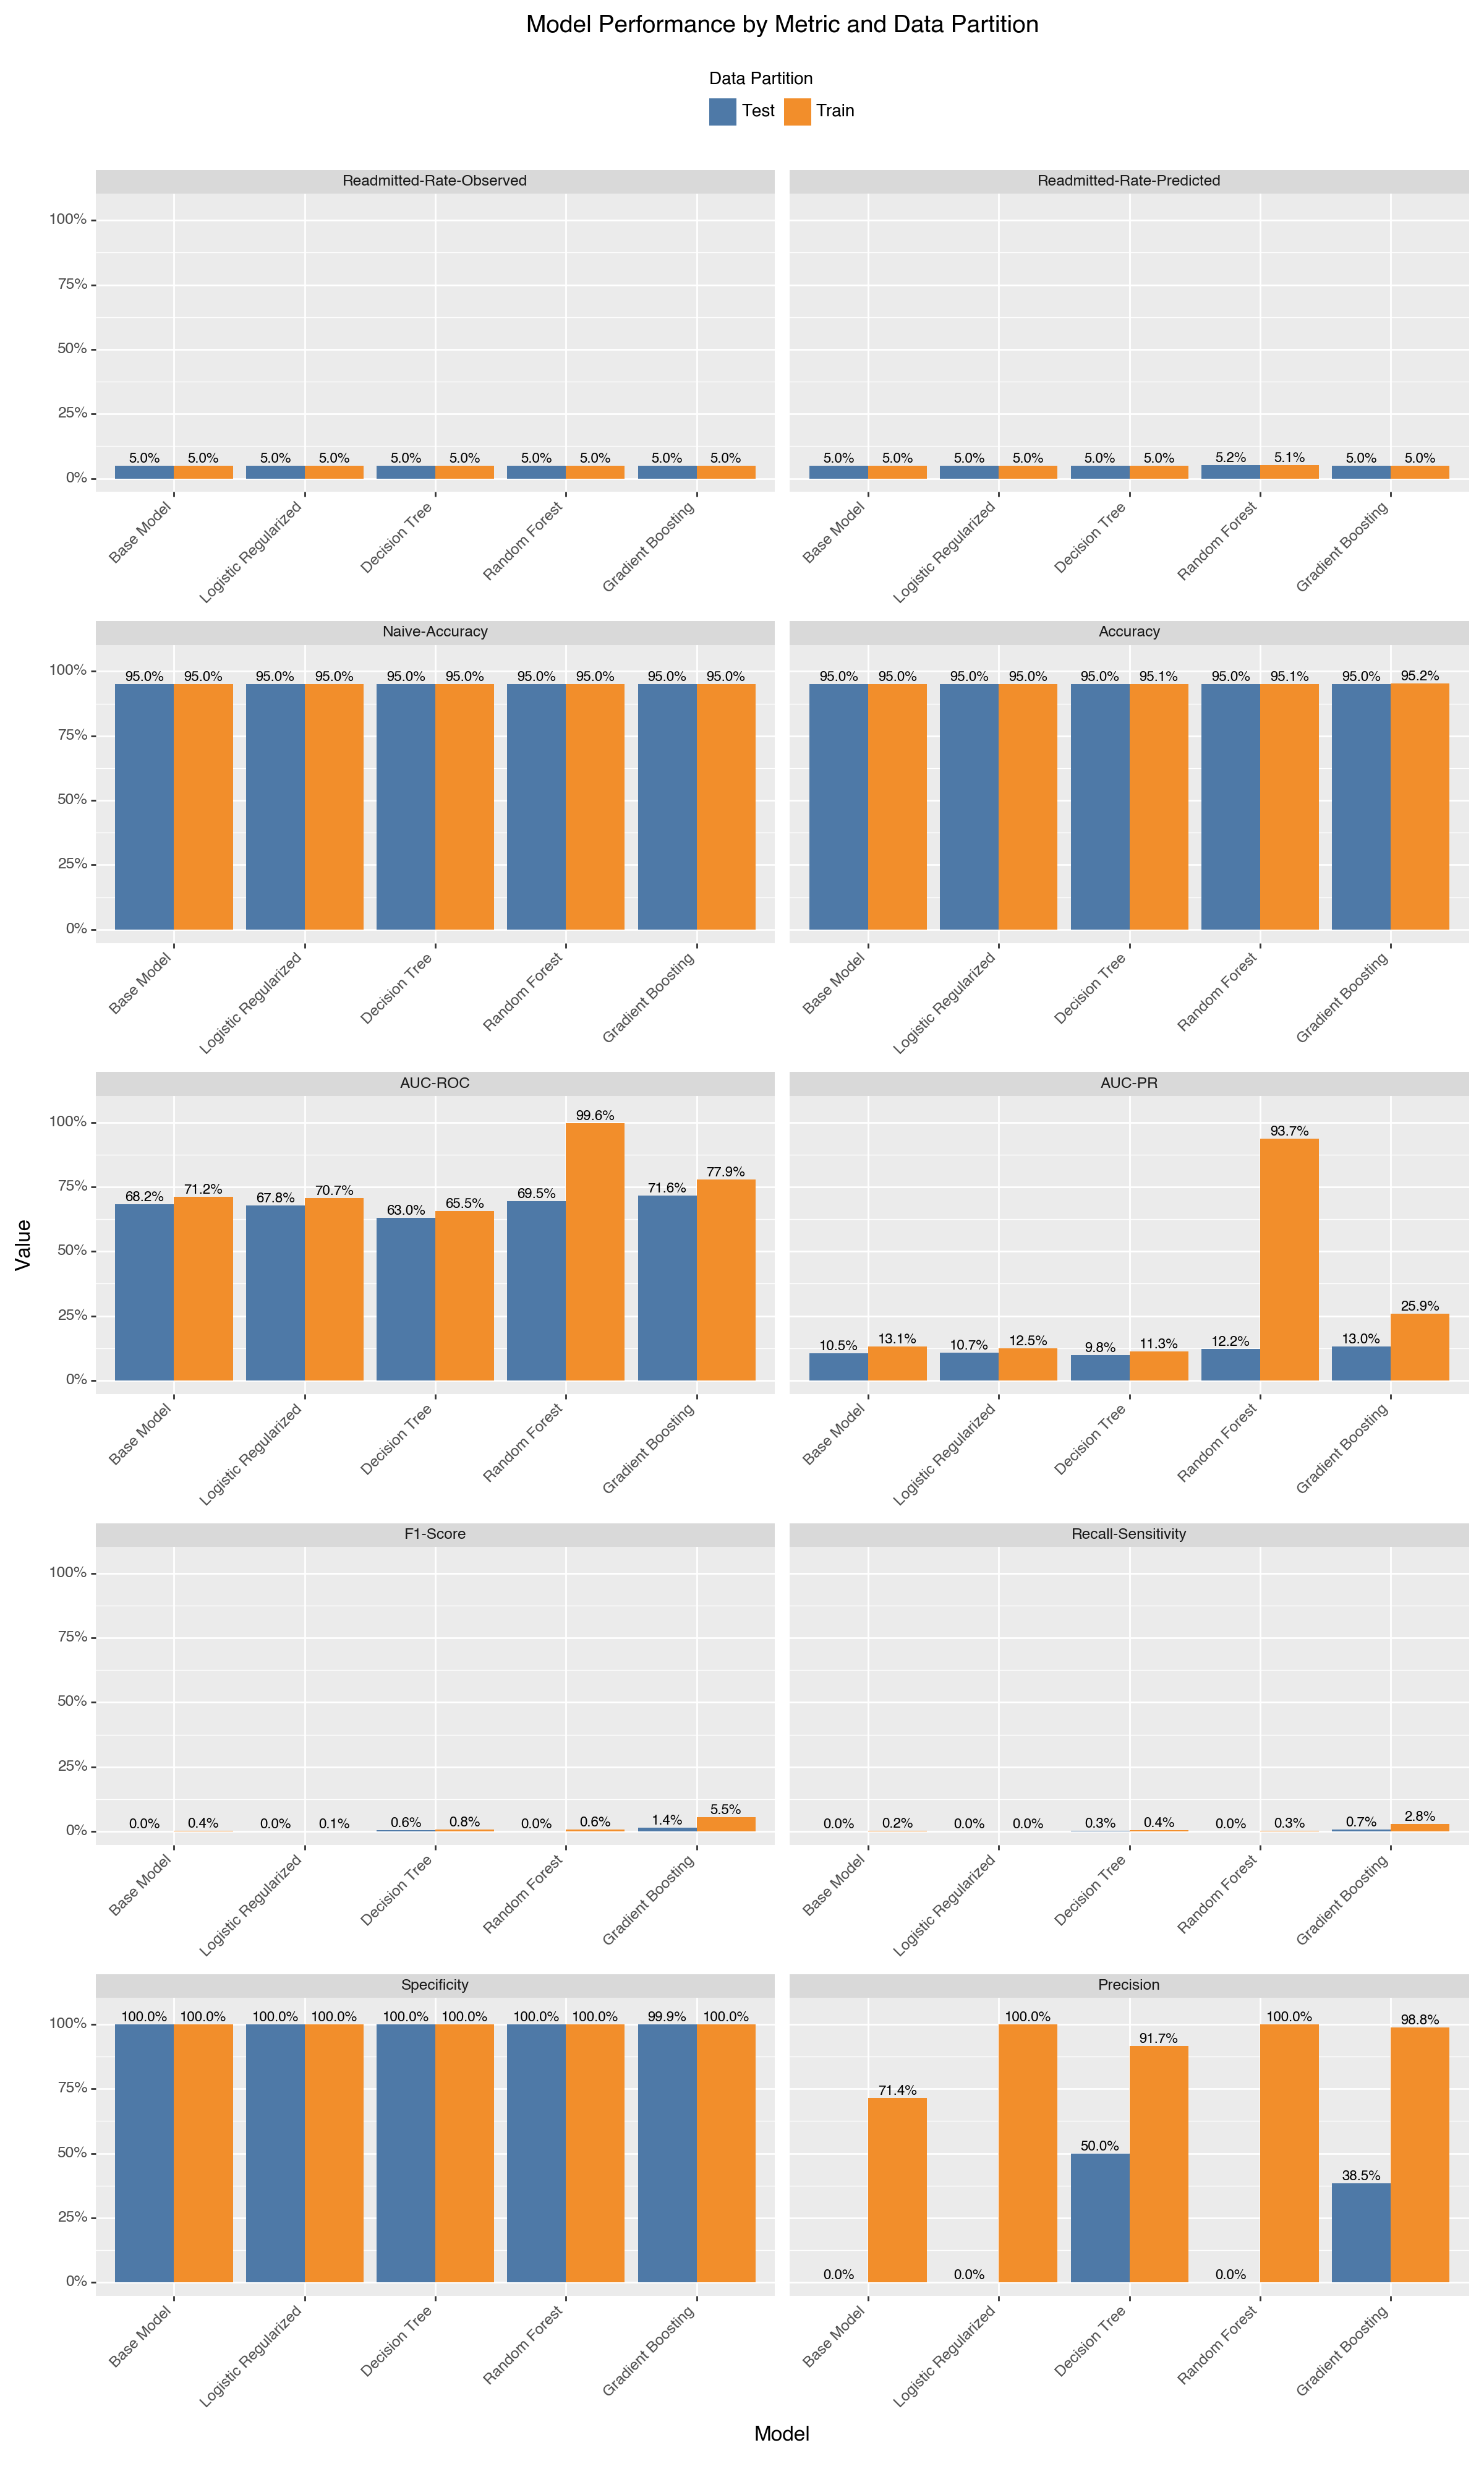

In [234]:
results_df = get_results_df(results)
plot_performance_metrics(results_df)

In [180]:
# dict of model names and classifiers for plotting curves
models = {
    "Base Model": base_model,
    "Logistic Regularized": lrr,
    "Decision Tree": dt,
    "Random Forest": rf,
    "Gradient Boosting": gb
}

# data
data = (X_train_transformed, X_test_transformed, y_train, y_test)

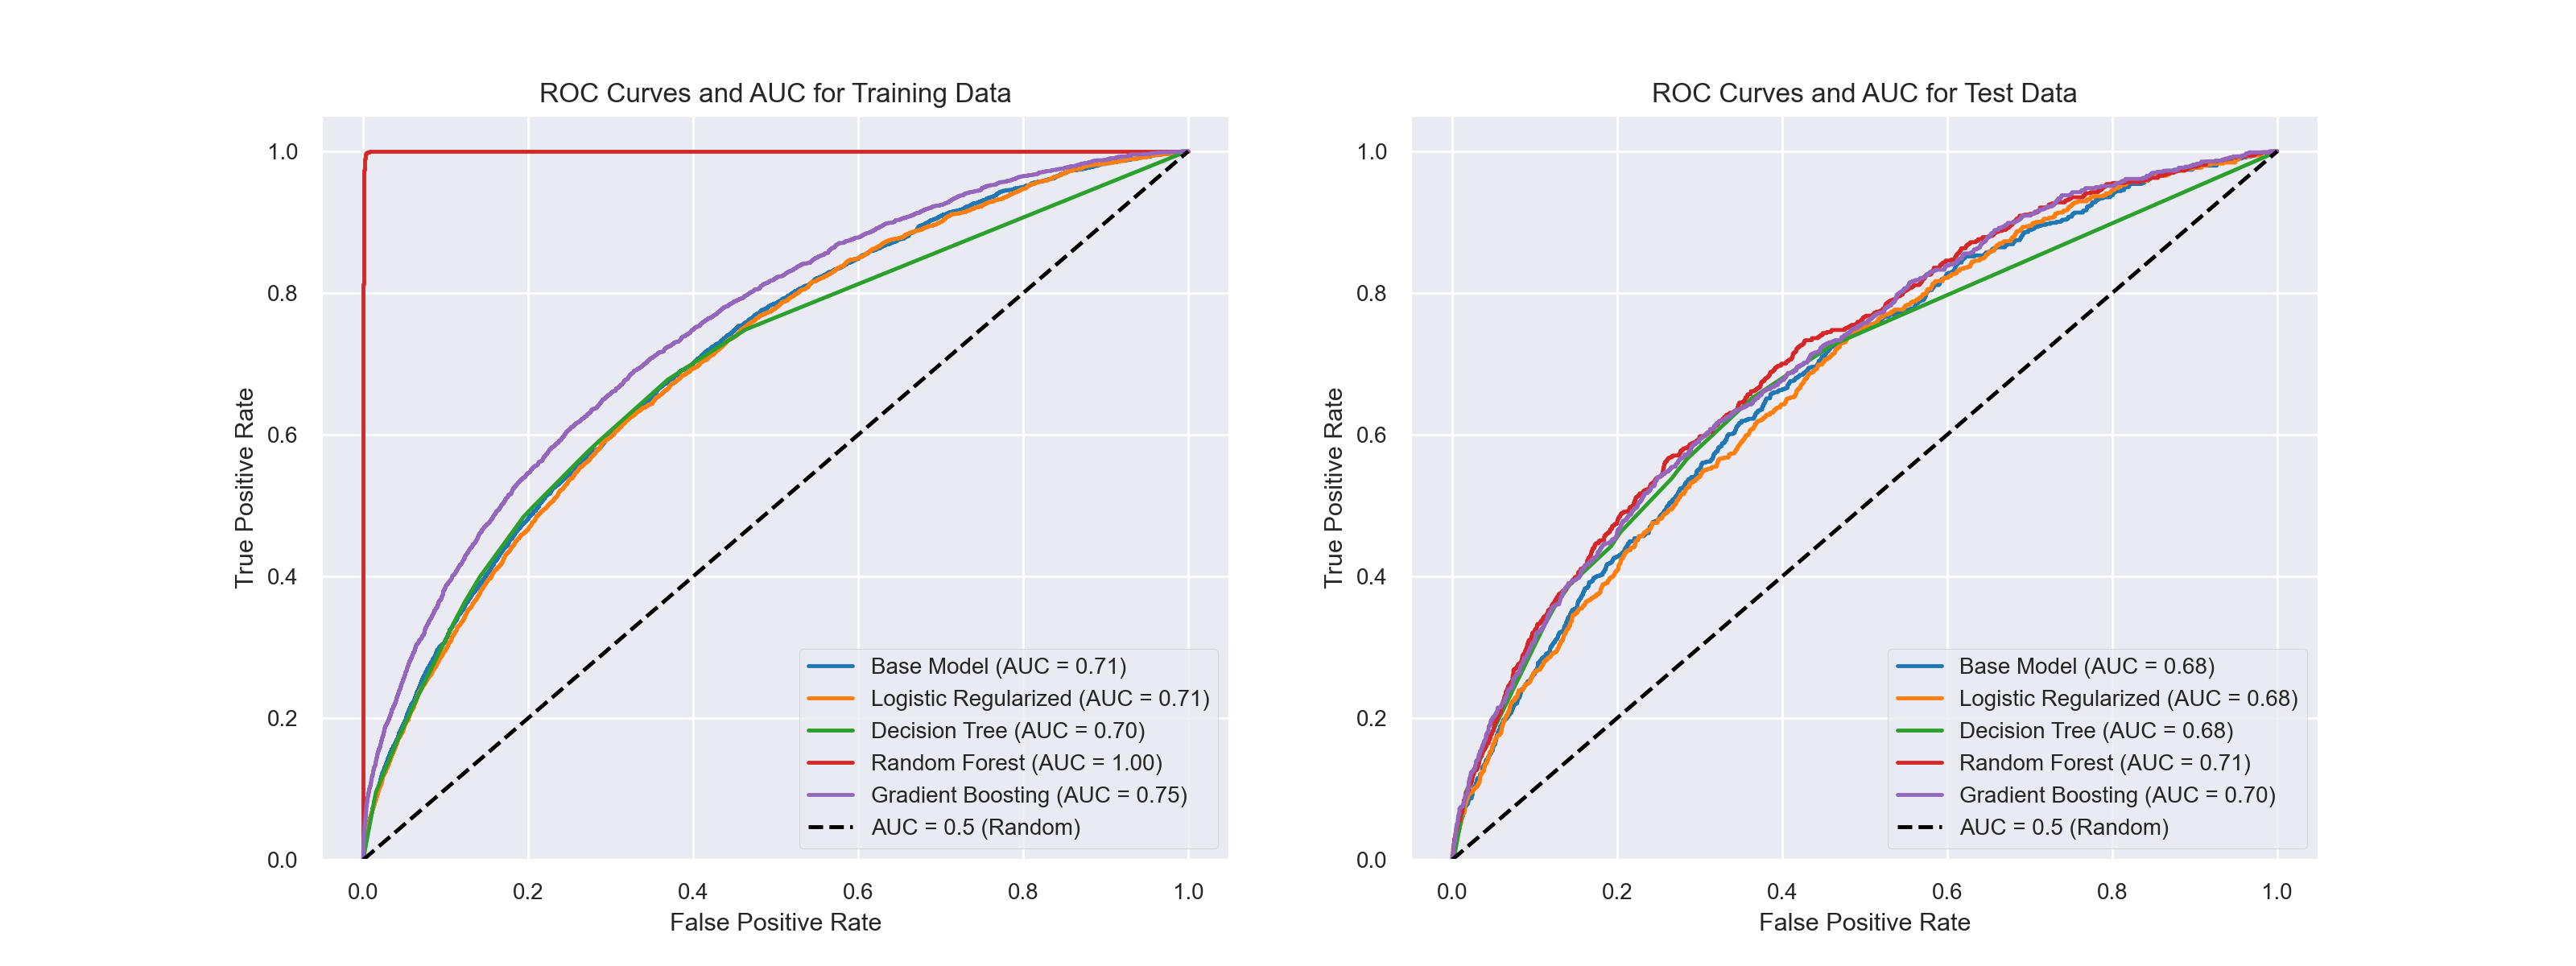

In [181]:
# ROC Curve
plot_ROC_curves(models, data)

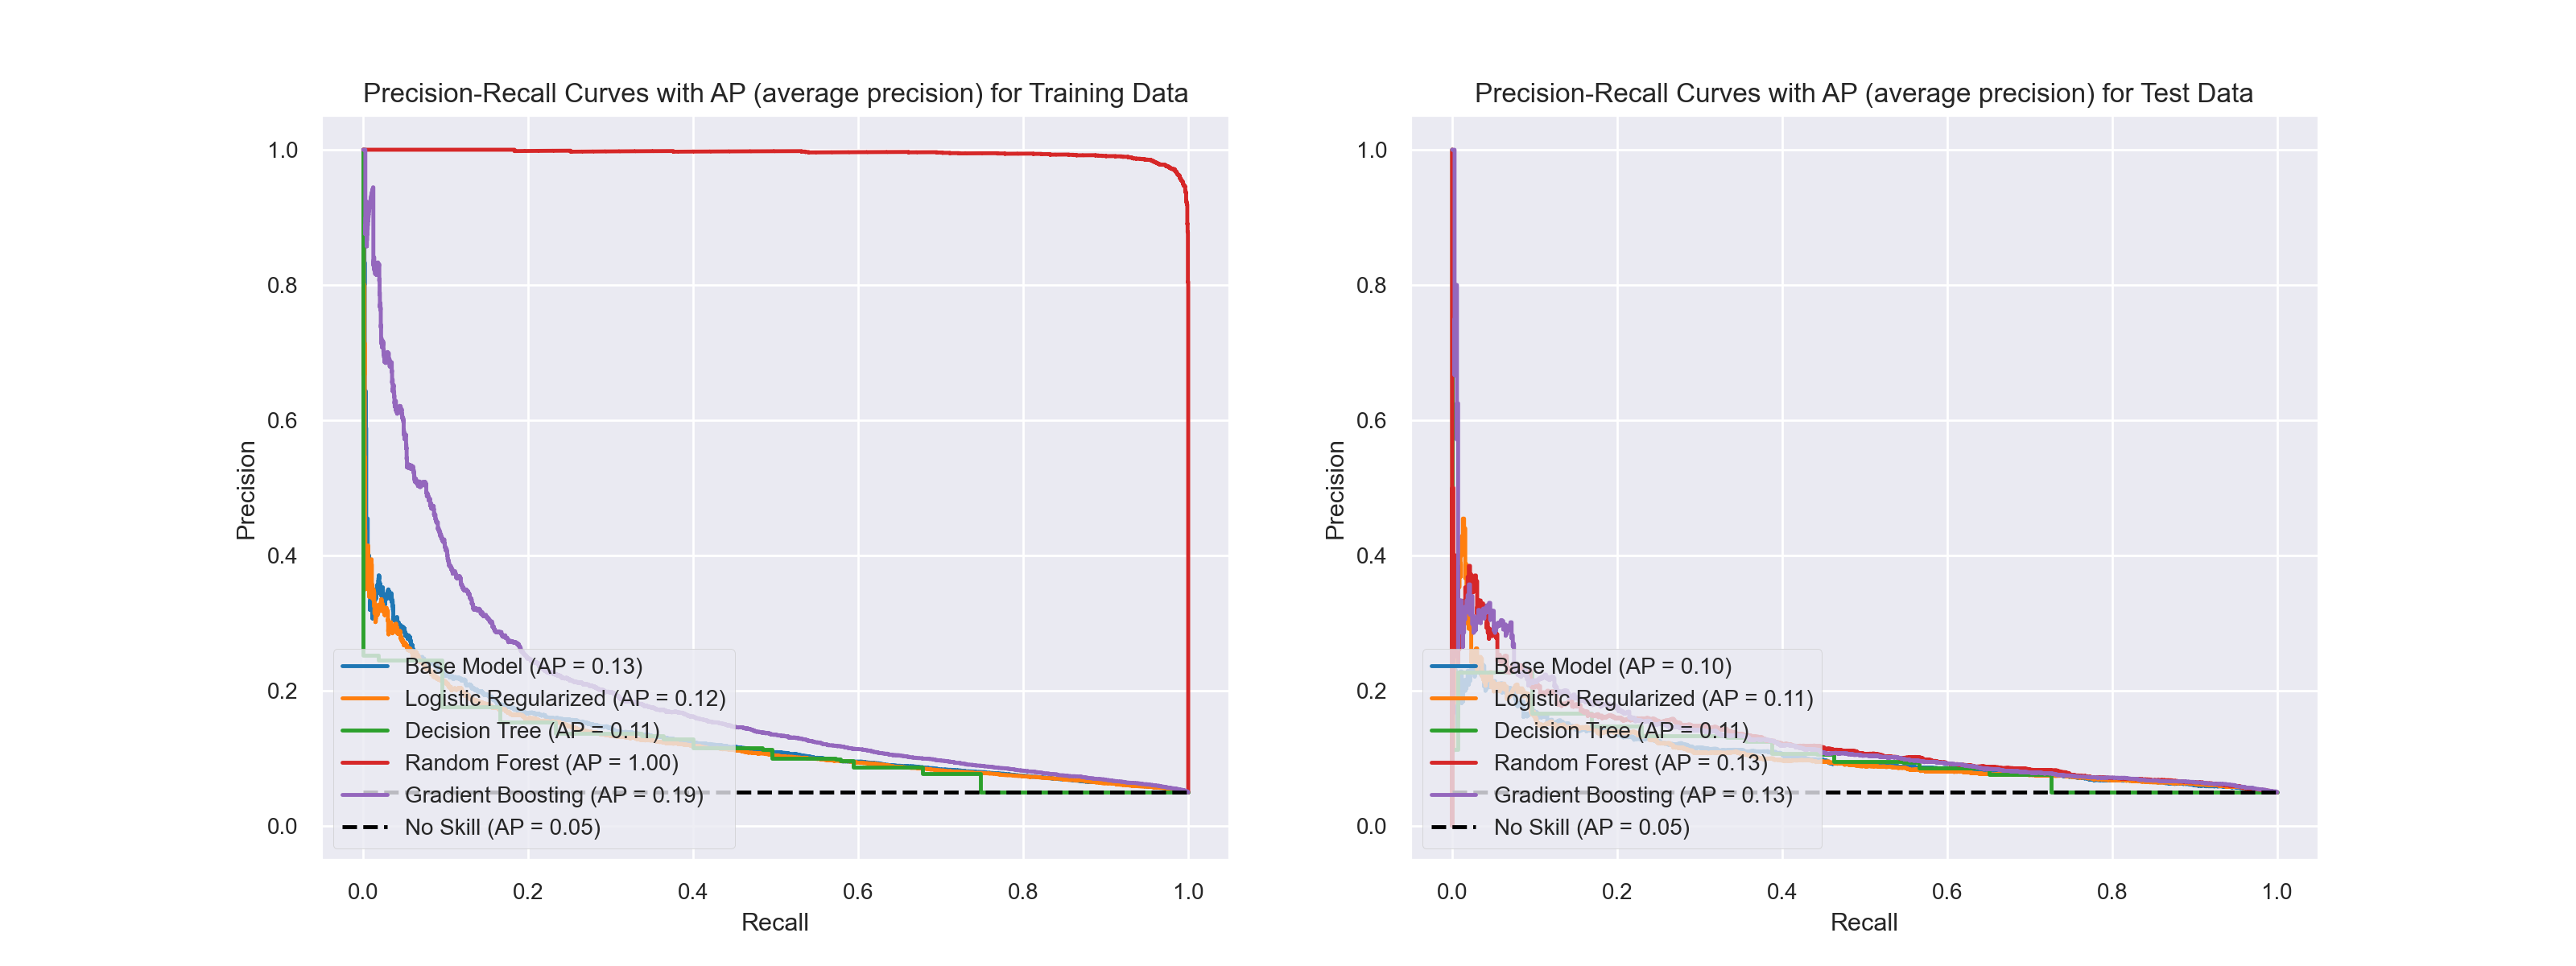

In [182]:
# Precision Recall Curve
plot_PR_curves(models, data)

<a name="5.3.-Variable-Importance"></a>
## 5.3 Variable Importance

[Return to top](#Notebook-Contents)

<a name="6.-Conclusions"></a>
# 6. Conclusions

[Return to top](#Notebook-Contents)

We found this project to be both interesting and quite challenging. Blah blah blah.

Perhaps the three most perplexing issues we encountered were:

1. placeholder1 

2. placeholder2

3. placeholder3

<a name="6.1.-Patient-Early-Readmittance-Rate"></a>
## 6.1 Patient Early Readmittance Rate

[Return to top](#Notebook-Contents)

<a name="6.2.-Patient-Risk-Profiles"></a>
## 6.2 Patient Risk Profiles

[Return to top](#Notebook-Contents)

<a name="7.-Future-Work"></a>
# 7. Future Work

[Return to top](#Notebook-Contents)

In our analysis of the Chest X-ray dataset we have tried a variety of modeling and feature engineering approaches, but there are still several additional steps that could be taken:

1. placeholder1

2. placeholder2

3. placeholder2

<a name="8.-References"></a>
# 8. References

[Return to top](#Notebook-Contents)

**The following are links to papers, blogs, and tutorials we found useful during the development of this project:**

Fine-tuning for transfer learning models:
https://keras.io/guides/transfer_learning/

Medical neural networks:
https://glassboxmedicine.com/

Image classification using CNNs:
https://towardsdatascience.com/medical-x-ray-%EF%B8%8F-image-classification-using-convolutional-neural-network-9a6d33b1c2a

Comparison of ResNet50 and VGG19 and training from stratch for X-ray images dataset:
https://www.sciencedirect.com/science/article/pii/S2666285X21000558

Tensorflow Applications for base model:
https://keras.io/api/applications/

Tensorboard confusion matrix:
https://towardsdatascience.com/exploring-confusion-matrix-evolution-on-tensorboard-e66b39f4ac12

Pre-processing and modeling pipelines (ResNet50):
https://towardsdatascience.com/time-to-choose-tensorflow-data-over-imagedatagenerator-215e594f2435

Image data input pipelines:
https://towardsdatascience.com/what-is-the-best-input-pipeline-to-train-image-classification-models-with-tf-keras-eb3fe26d3cc5

Split TF datasets:
https://towardsdatascience.com/how-to-split-a-tensorflow-dataset-into-train-validation-and-test-sets-526c8dd29438

Transfer learning with EfficientNet:
https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

Training greyscale images using transfer learning:
https://stackoverflow.com/questions/51995977/how-can-i-use-a-pre-trained-neural-network-with-grayscale-images

Multi-label vs multi-class classification:
https://glassboxmedicine.com/2019/05/26/classification-sigmoid-vs-softmax/

Multi-label classification example use-case:
https://towardsdatascience.com/fast-ai-season-1-episode-3-a-case-of-multi-label-classification-a4a90672a889

Element-wise sigmoid:
https://www.programcreek.com/python/example/93769/keras.backend.sigmoid

Element-wise sigmoid:
https://stackoverflow.com/questions/52090857/how-to-apply-sigmoid-function-for-each-outputs-in-keras

DenseNet121:
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8189817/